<a href="https://colab.research.google.com/github/madynamics/Noise-modelling/blob/main/facial_keypoints_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

0. Download data from kaggle/google drive

In [ ]:
!pip install kaggle
from google.colab import drive
drive.mount('/content/drive')
! mkdir /root/.kaggle
!cp /content/drive/MyDrive/ColabNotebooks/kaggle/kaggle.json /root/.kaggle/kaggle.json
! chmod 600 /root/.kaggle/kaggle.json
! kaggle competitions download -c facial-keypoints-detection
! unzip /content/facial-keypoints-detection.zip
! unzip /content/test.zip
! unzip /content/training.zip

1. Preliminary check of data and pre-processing

In [ ]:
## 0.Overview of data

import pandas as pd
import numpy as np
import torch

train = pd.read_csv("training.csv")
test = pd.read_csv("test.csv")

train_images = train['Image']
traincheck = train.drop(columns='Image')
traincheck.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166


In [ ]:
train_images

0       238 236 237 238 240 240 239 241 241 243 240 23...
1       219 215 204 196 204 211 212 200 180 168 178 19...
2       144 142 159 180 188 188 184 180 167 132 84 59 ...
3       193 192 193 194 194 194 193 192 168 111 50 12 ...
4       147 148 160 196 215 214 216 217 219 220 206 18...
                              ...                        
7044    71 74 85 105 116 128 139 150 170 187 201 209 2...
7045    60 60 62 57 55 51 49 48 50 53 56 56 106 89 77 ...
7046    74 74 74 78 79 79 79 81 77 78 80 73 72 81 77 1...
7047    254 254 254 254 254 238 193 145 121 118 119 10...
7048    53 62 67 76 86 91 97 105 105 106 107 108 112 1...
Name: Image, Length: 7049, dtype: object

In [ ]:
## 1. Data preprocessing

# note that train_images.iloc[1] is a long string spaced by ' '
trainimgs = [np.fromstring(train_images.iloc[i], sep=' ').reshape([96,96]) for i in range(train_images.size)]
# .values is to remove the axis labels
trainpits = [traincheck.iloc[i].values.reshape([15,2]) for i in range(traincheck.shape[0]) ]

In [ ]:
print(trainpits[0])
trainimgs_np = np.array(trainimgs)
print((trainimgs_np/255).mean())
print((trainimgs_np/255).std())

[[66.03356391 39.00227368]
 [30.22700752 36.4216782 ]
 [59.58207519 39.64742256]
 [73.13034586 39.96999699]
 [36.35657143 37.3894015 ]
 [23.45287218 37.3894015 ]
 [56.95326316 29.03364812]
 [80.22712782 32.22813835]
 [40.22760902 29.0023218 ]
 [16.35637895 29.64747068]
 [44.42057143 57.06680301]
 [61.19530827 79.97016541]
 [28.61449624 77.38899248]
 [43.3126015  72.93545865]
 [43.13070677 84.48577444]]
0.4895869584713929
0.23274213894878826


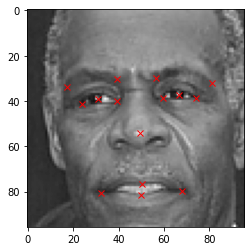

In [ ]:
import matplotlib.pyplot as plt

j = 2000
plt.imshow(trainimgs[j], cmap='gray')
plt.plot(trainpits[j][:,0], trainpits[j][:,1], 'rx')

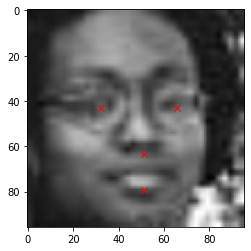

In [ ]:
j = 3000
plt.imshow(trainimgs[j], cmap='gray')
plt.plot(trainpits[j][:,0], trainpits[j][:,1], 'rx')

In [ ]:
train_15_landmarks = train[~ (train.isnull().sum(axis=1)>20)].copy()
train_4_landmarks = train[(train.isnull().sum(axis=1)>20)].copy()

In [ ]:
train_15_landmarks.iloc[0:100,:].to_csv("val_15.csv",index=False)
train_15_landmarks.iloc[100:,:].to_csv("train_15.csv",index=False)
train_4_landmarks.iloc[0:200,:].to_csv("val_4.csv",index=False)
train_4_landmarks.iloc[200:,:].to_csv("train_4.csv",index=False)

2. Data loader

In [ ]:
## 2. Define the dataset

from torch.utils.data import DataLoader, Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

train_transforms = A.Compose(
    [
        A.Resize(width=96, height=96), # it should be already 96x96, but for safety
        A.Rotate(limit=15, border_mode=cv2.BORDER_CONSTANT, p=0.8),
        A.Affine(shear=15, scale=1.0, mode=0, p=0.2),
        A.RandomBrightnessContrast(contrast_limit=0.5, brightness_limit=0.5, p=0.2),
        A.OneOf([
            A.GaussNoise(p=0.8),
            A.CLAHE(p=0.8),
            A.ImageCompression(p=0.8),
            A.RandomGamma(p=0.8),
            A.Posterize(p=0.8),
            A.Blur(p=0.8),
        ], p=1.0),
        A.OneOf([
            A.GaussNoise(p=0.8),
            A.CLAHE(p=0.8),
            A.ImageCompression(p=0.8),
            A.RandomGamma(p=0.8),
            A.Posterize(p=0.8),
            A.Blur(p=0.8),
        ], p=1.0),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=0, p=0.2, border_mode=cv2.BORDER_CONSTANT),
        A.Normalize(
            mean=[0.4896, 0.4896, 0.4896],
            std=[0.2327, 0.2327, 0.2327],
            max_pixel_value=255.0,
        ), 
        # 1) normalise the pixel with the mean and std, check the official document
        # for the formula; 2) the original data is in gray scale, since I am trying to use
        # pre-trained model (for rgb data), I just need to have three channels, therefore I
        # repeat the channels three times so that we can send it to efficient 0
        ToTensorV2(),
    ], keypoint_params=A.KeypointParams(format="xy", remove_invisible=False),
)


val_transforms = A.Compose(
    [
        A.Resize(height=96, width=96),
        A.Normalize(
            mean=[0.4896, 0.4896, 0.4896],
            std=[0.2327, 0.2327, 0.2327],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ], keypoint_params=A.KeypointParams(format="xy", remove_invisible=False),
)

class FacialKeypointDataset(Dataset):
    def __init__(self, csv_file, train=True, transform=None):
        super().__init__()
        self.data = pd.read_csv(csv_file)
        self.category_names = ['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x', 'right_eye_center_y', 'left_eye_inner_corner_x', 'left_eye_inner_corner_y', 'left_eye_outer_corner_x', 'left_eye_outer_corner_y', 'right_eye_inner_corner_x', 'right_eye_inner_corner_y', 'right_eye_outer_corner_x', 'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y', 'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x', 'mouth_right_corner_y', 'mouth_center_top_lip_x', 'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y']
        self.transform = transform
        self.train = train

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):
        if self.train:
            image = np.array(self.data.iloc[index, 30].split()).astype(np.float32)
            labels = np.array(self.data.iloc[index, :30].tolist())
            labels[np.isnan(labels)] = -1
            # turn all the NaN into -1, so that we may ignore them in training
        else: 
            # note that for the test set the data structure is a bit different;
            image = np.array(self.data.iloc[index, 1].split()).astype(np.float32)
            # for test set, we do not have the coordinates of keypoints, so we 
            # just set it to zeros
            labels = np.zeros(30)

        ignore_indices = labels == -1
        labels = labels.reshape(15, 2)

        if self.transform:
            image = np.repeat(image.reshape(96, 96, 1), 3, 2).astype(np.uint8)
            # repeat to have three channel, along the channel 2 (so the third channel)
            augmentations = self.transform(image=image, keypoints=labels)
            # use the transform from albumentation for the data
            image = augmentations["image"]
            labels = augmentations["keypoints"]

        labels = np.array(labels).reshape(-1)
        # let the NaNs go back to zeros
        labels[ignore_indices] = -1

        return image, labels.astype(np.float32)

temp device: False
x: [69.224075 29.591566 60.701767 79.65716  38.39064  18.646675 61.63178
 88.26965  39.290043 12.976811 46.989277 68.095535 23.61358  45.065784
 43.53388 ]
y: [38.578773 34.13949  39.626442 39.9062   36.390034 33.50375  30.84338
 33.630264 28.340855 24.409908 61.46448  74.00386  69.57463  73.269554
 87.04391 ]


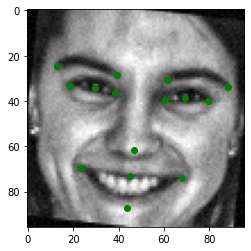

temp device: False
x: [68.59369  32.622887 62.341587 75.88368  38.948868 25.112633 62.34092
 81.86853  42.601856 23.358278 47.02048  58.361103 28.54162  45.296288
 43.5009  ]
y: [39.945683 33.578354 40.212917 41.946457 35.982635 32.71626  31.059437
 35.427246 29.308083 24.995214 53.783283 76.05478  71.467964 68.803795
 82.201126]


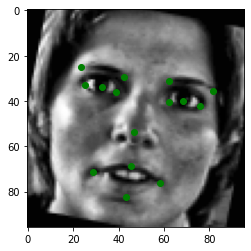

temp device: False
x: [62.593895 28.82643  55.790493 68.28811  34.67189  23.649275 54.009228
 70.835335 34.94703  17.829065 47.274357 64.426445 40.374977 50.07357
 53.65573 ]
y: [31.701923 39.78752  33.376278 31.303396 38.16126  41.936096 25.805883
 22.525913 30.57025  34.413593 44.771935 66.23945  72.22235  60.14621
 74.51769 ]


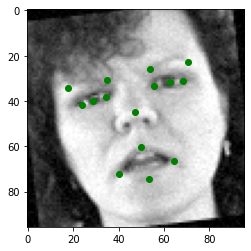

temp device: False
x: [64.25445  32.503    56.193203 68.9338   38.39105  23.353338 51.97947
 71.59267  39.498447 11.838466 56.946793 70.92779  36.771835 58.60802
 60.309227]
y: [30.495815 41.30527  35.24288  28.613623 41.54291  45.02579  28.006773
 18.366701 30.932697 39.68459  55.14978  63.820915 76.90703  70.818275
 78.686516]


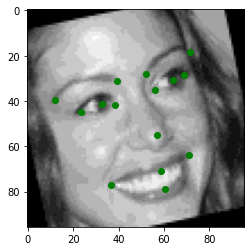

temp device: False
x: [61.74066  28.539846 55.488102 69.31589  35.539265 21.009968 48.32897
 67.94795  32.071365 10.442307 51.41278  84.131485 48.783638 62.55852
 65.379616]
y: [26.705915 50.868343 31.69604  22.505392 47.160065 57.151325 24.86081
  9.660741 37.568287 50.9819   53.38998  63.407055 85.40045  74.82603
 79.25784 ]


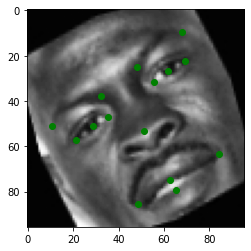

temp device: False
x: [65.4785   32.376453 60.283756 71.294586 38.14074  27.681738 57.00511
 78.68189  46.201492 21.538012 47.720665 52.962315 32.90729  44.90306
 41.691483]
y: [37.627083 31.479914 37.920113 38.956604 33.10283  30.650995 27.357143
 34.815052 25.147072 22.607708 53.926254 75.95858  73.022804 68.48477
 81.53243 ]


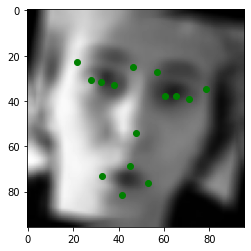

temp device: False
x: [65.18136  30.164194 59.43042  71.7475   36.156857 24.43261  57.490696
 78.55037  38.428436 17.354744 50.26911  65.394966 40.557743 52.87492
 54.33741 ]
y: [38.943855 40.046547 38.66783  38.452335 40.71269  41.146317 29.321728
 29.389404 31.380075 33.11803  62.18502  82.914276 85.77828  79.852905
 91.6696  ]


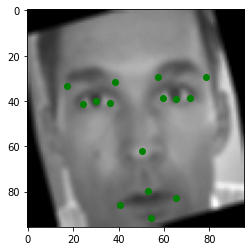

temp device: False
x: [58.176617 30.854094 54.005833 63.966877 36.54013  25.566456 48.069992
 66.18227  33.149006 17.582163 53.394863 71.884315 48.030685 58.04646
 63.679585]
y: [31.529142 47.16636  34.92159  29.407597 44.803967 51.079422 26.11152
 20.848408 35.675526 48.72476  53.44282  62.7661   76.49598  64.87763
 76.72389 ]


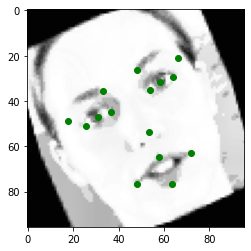

temp device: False
x: [59.388054 30.39     53.41883  67.325    37.32925  22.671    46.3928
 68.78     35.790806 14.911    52.807865 72.3015   49.085514 60.332115
 60.96817 ]
y: [31.2007   45.274    34.446735 27.678    41.439625 48.926    26.815567
 19.056    32.371964 44.703    55.474907 64.397705 76.396    70.180016
 71.018456]


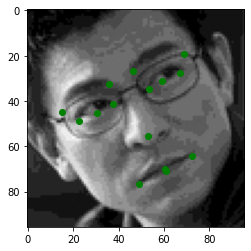

temp device: False
x: [64.4642    22.665981  54.6968    73.25521   30.597902  11.736714
 47.17883   77.187836  29.327827   3.1146197 42.02042   72.196655
 38.82918   54.981987  55.68606  ]
y: [29.25694  42.158123 34.280327 27.189632 42.954105 45.09575  26.59716
 17.512722 32.888832 38.802567 63.19739  75.315094 86.50375  80.24776
 82.55448 ]


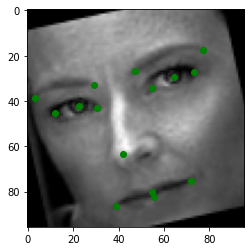

temp device: False
x: [68.14273  29.780897 61.768734 74.25976  36.266136 22.715456 59.769604
 81.077095 40.46942  15.5728   49.43208  59.641434 28.49973  45.501812
 44.630466]
y: [39.98147  33.659134 40.356804 41.809128 35.530186 33.582317 31.93306
 34.41047  28.19968  24.560287 56.795406 81.06767  76.702    74.58301
 85.2803  ]


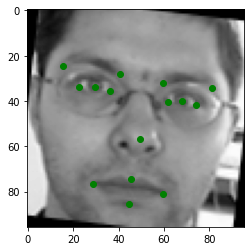

temp device: False
x: [64.45385  31.630358 56.227222 73.34166  38.82845  21.325796 52.518913
 80.67536  42.09847  15.486666 45.88876  63.265327 32.572334 47.040173
 47.821205]
y: [37.324135 37.867775 38.97077  38.121532 39.35555  38.527084 33.234287
 32.207417 32.98219  33.1616   60.03603  79.75503  79.92766  77.16216
 88.2272  ]


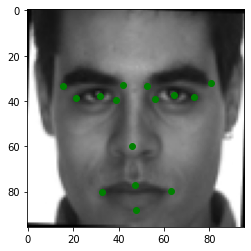

temp device: False
x: [62.56895  29.588717 56.40078  71.060196 37.871353 23.843874 52.76871
 80.19115  36.43658  17.183916 42.466423 59.96999  36.0636   46.12349
 45.911243]
y: [38.681656 41.32793  38.483555 39.037254 40.103687 42.755352 28.836113
 25.90317  30.343227 29.454916 57.53022  77.42619  77.9947   75.38697
 78.86265 ]


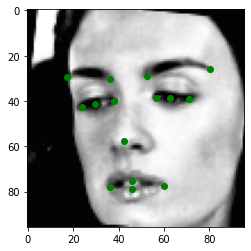

temp device: False
x: [60.76498  31.278748 54.510273 64.50527  35.665    24.713821 50.684826
 70.62321  37.23545  15.344666 56.772198 73.71442  40.992863 59.998863
 62.05784 ]
y: [30.926971 43.94245  34.534138 29.712954 42.92524  47.284847 28.67602
 24.82712  34.62058  48.108284 59.551224 65.83501  81.207954 75.93265
 83.63591 ]


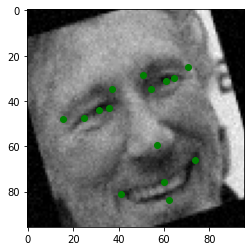

temp device: False
x: [-1.       -1.       58.031765 72.79617  37.68913  24.276268 56.155533
 78.4043   39.54592  20.792053 34.791233 49.823803 23.206236 36.37996
 35.61402 ]
y: [-1.       -1.       42.50083  49.069073 34.949734 31.515038 35.601154
 41.55132  31.653511 21.461422 62.996056 81.25405  69.707954 78.15275
 80.56399 ]


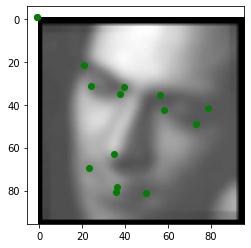

temp device: False
x: [60.60958  31.190348 55.41672  67.25554  37.521046 24.680706 50.399952
 67.41527  38.205204 15.903519 59.512863 72.88765  50.477352 63.16577
 64.089554]
y: [31.476805 44.45978  35.815754 30.44627  44.158276 48.847477 28.505804
 20.718033 33.13204  44.962147 57.817818 68.44257  80.34918  74.450035
 75.45143 ]


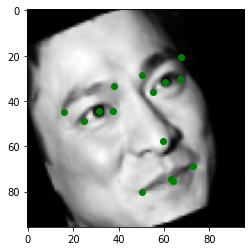

temp device: False
x: [65.05188  35.680325 60.301533 72.47481  41.414097 32.095478 58.607956
 78.57572  44.3129   30.729418 32.2296   58.355022 31.16074  41.33999
 40.875393]
y: [42.005127 32.116993 41.875835 44.806488 35.68685  30.650616 32.470055
 38.147503 30.29568  18.599052 55.374073 75.56999  65.24349  72.820724
 75.515305]


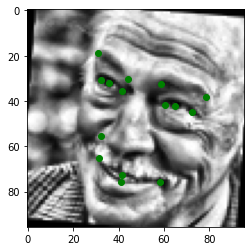

temp device: False
x: [68.245186 30.573622 59.572994 74.76977  37.091576 21.376678 58.35764
 80.61062  42.12171  11.202422 57.948685 67.40172  35.60814  54.538284
 53.6824  ]
y: [38.2878   38.591602 39.530632 39.295322 38.757313 39.14397  30.925821
 29.85319  29.996206 34.729538 57.01742  77.41305  79.67863  77.866165
 79.12482 ]


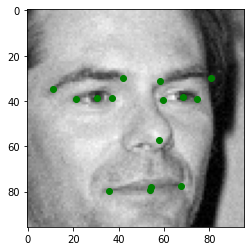

temp device: False
x: [63.528316 26.998322 56.13018  71.04314  34.86335  19.156527 51.94901
 77.75615  35.915207  9.578873 46.892815 65.11375  34.019474 48.70639
 49.250725]
y: [34.578354 40.82862  38.082016 34.18963  41.179386 42.821346 31.548147
 25.032366 34.79411  36.941162 60.84298  73.498726 77.265236 73.660866
 82.460304]


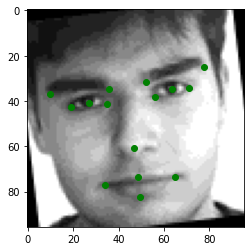

temp device: False
x: [68.5004   29.522633 61.885464 76.4645   36.07278  23.166798 53.97222
 78.94779  38.430016 15.568537 48.43313  69.53418  38.196556 52.699158
 54.45416 ]
y: [33.61035  39.135746 33.94261  33.33991  38.482384 40.752197 24.523657
 20.81111  26.981386 29.589254 55.03255  75.16514  78.81444  71.21146
 83.21879 ]


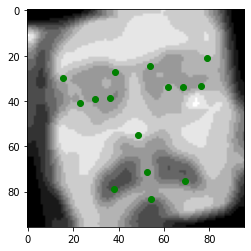

temp device: False
x: [62.05554  32.759434 55.327717 68.264206 38.999016 24.53529  48.877357
 69.25872  37.178654 18.588861 53.75419  72.76398  45.024323 59.564552
 61.078754]
y: [22.902605 35.16574  27.111588 21.054863 33.811497 39.132576 18.788334
 11.557445 27.403688 33.998867 50.04963  53.735725 65.55617  61.35219
 65.05876 ]


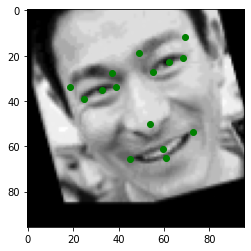

temp device: False
x: [65.32436   23.595617  54.129322  73.659706  33.388023  13.418417
 53.64718   78.01914   36.059887   7.9614744 40.9204    53.951103
 16.63164   34.802116  34.690952 ]
y: [40.04565  32.656414 39.59731  40.649986 35.406807 31.048237 31.310568
 37.971348 27.273956 24.391891 62.093216 87.85465  79.40683  81.185745
 82.384514]


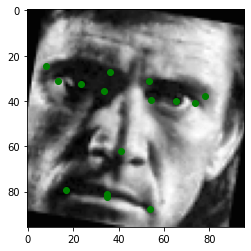

temp device: False
x: [65.10317  33.217407 57.09136  72.943306 39.209152 22.605383 57.573746
 74.1866   40.157326 17.769308 54.089375 66.29146  33.385452 52.177044
 53.075706]
y: [32.39553  37.1686   34.232555 31.914322 37.78175  39.709797 27.112898
 21.861605 29.232513 30.672167 58.95589  67.51363  71.85281  72.9247
 76.971596]


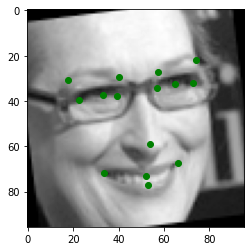

temp device: False
x: [64.00435  28.777632 56.40637  73.84699  37.756893 19.625631 53.98866
 82.13561  39.48365  11.854913 47.599533 63.83161  33.26726  47.77227
 48.462914]
y: [35.58058  35.235416 36.962173 35.92606  36.789436 36.271534 27.637438
 29.882408 28.500816 29.536932 57.85631  74.26082  75.64241  72.188896
 80.30478 ]


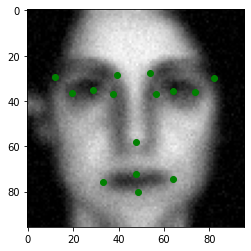

temp device: False
x: [68.31512  32.705135 62.235775 74.65215  37.539955 26.32495  61.75113
 85.01321  43.571995 22.302652 44.875984 50.28717  25.016325 40.142906
 37.126736]
y: [44.30534  32.70482  43.234447 47.01539  35.072212 31.565304 34.27113
 41.790535 26.646904 21.47926  61.902836 87.30201  80.27319  77.71643
 90.939545]


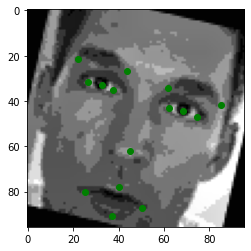

temp device: False
x: [65.08433  26.587158 58.10086  72.19659  33.019253 20.83613  52.59511
 75.84655  30.73292  13.168697 51.321983 73.273445 38.270065 54.040615
 57.657173]
y: [32.526638 41.82811  33.97696  32.15648  40.344757 44.424454 24.315626
 24.117674 28.594662 36.878883 51.788094 66.20003  75.96621  67.24884
 77.42249 ]


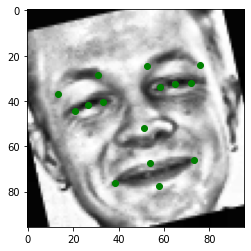

temp device: False
x: [67.84018  32.10699  62.3979   72.43023  36.75831  26.811441 57.3681
 80.53648  45.325027 21.70788  43.30173  54.28654  24.628944 40.199215
 36.988525]
y: [41.315018 34.29806  40.926533 42.26366  36.73194  33.203613 31.419538
 35.103397 27.70643  24.049519 63.85475  81.955444 75.826004 73.5214
 89.05648 ]


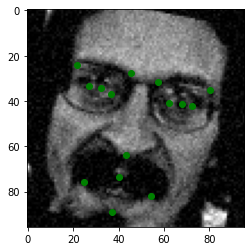

temp device: False
x: [64.10985  31.99869  58.57477  68.53966  36.982914 27.294619 58.567284
 75.45222  39.466827 22.3054   47.52611  55.572464 36.194798 45.877388
 45.339733]
y: [34.360836 31.911158 34.92167  35.461914 33.565228 33.300858 29.108782
 29.640608 28.02623  27.771488 53.20441  67.8641   66.5048   62.340786
 74.796715]


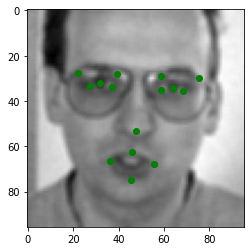

temp device: False
x: [57.609684 32.96685  53.567547 65.66431  37.792324 29.09374  41.620026
 68.267456 34.460922 23.080046 40.748066 71.65516  49.403194 55.518864
 57.490788]
y: [30.417322 42.842907 34.23733  29.164013 41.437065 46.385975 31.284832
 25.573093 37.658436 45.39539  65.568405 74.47382  84.198975 78.63541
 82.2275  ]


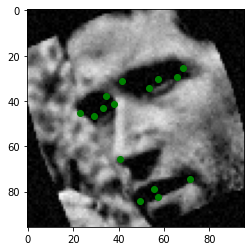

temp device: False
x: [69.49914  37.069954 64.04609  74.19055  42.23323  33.17315  59.912827
 78.01137  42.68333  25.722878 55.598377 72.90426  49.58874  59.098923
 62.889366]
y: [37.145153 44.531513 38.38446  36.673687 43.341793 46.14777  31.729887
 27.718637 35.59458  41.011673 51.635746 72.369865 77.26019  66.70701
 81.72938 ]


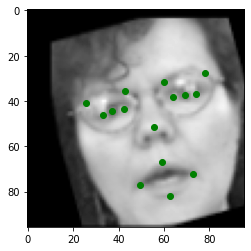

temp device: False
x: [60.91181  30.344599 56.271584 66.598526 36.99324  24.164207 49.857197
 69.72698  35.975254 17.254414 50.425022 69.50868  43.64023  56.089806
 57.21549 ]
y: [32.111774 41.629414 34.63684  31.474365 40.966568 45.040337 26.833221
 21.923714 31.401445 37.67891  59.085815 70.59713  78.63997  72.71042
 76.31363 ]


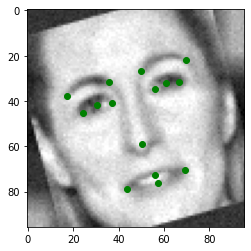

temp device: False
x: [61.03908  26.467749 54.19324  69.254395 33.796913 18.970457 47.289707
 74.2017   36.16815  10.338668 49.29365  68.41861  40.354275 53.069984
 55.149582]
y: [32.120674 41.760105 34.856724 30.827785 40.014652 44.636654 28.03021
 20.387892 31.230883 38.85592  56.359577 72.69245  80.3298   72.88827
 82.14204 ]


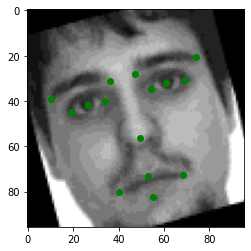

temp device: False
x: [65.86352  29.927023 61.071636 71.23232  35.988018 25.221535 56.71542
 77.95939  38.385834 14.88897  50.17385  66.80931  39.70593  50.38694
 52.837704]
y: [32.21491  36.105476 33.715103 33.31271  36.395176 38.731285 21.21611
 22.605253 23.377806 31.97536  48.24979  69.1323   70.079926 61.711273
 78.88609 ]


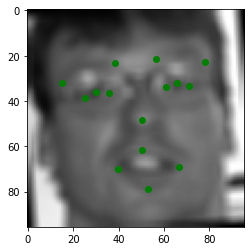

temp device: False
x: [66.12326  31.315002 60.946278 73.58948  37.21159  25.199545 56.775578
 80.969246 43.23033  19.692823 46.097115 60.61484  29.765331 43.557644
 42.430386]
y: [37.529316 34.585705 38.598576 39.440426 36.566208 37.37737  26.736483
 31.83026  28.175749 29.216297 52.422153 78.39473  75.83606  65.981674
 89.284   ]


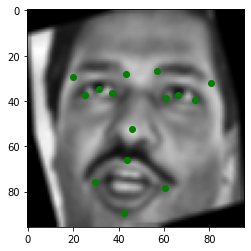

temp device: False
x: [70.96512  34.120056 63.328457 77.902176 41.19601  27.35694  59.92804
 83.40184  40.75327  20.267319 54.398006 72.599365 40.864788 55.675125
 58.13618 ]
y: [30.063066 34.046276 31.030642 30.903585 33.69754  36.743973 17.997334
 22.554052 20.71562  28.818274 41.71613  67.22096  70.9523   55.642403
 77.58793 ]


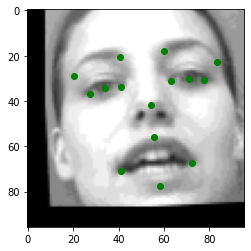

temp device: False
x: [61.79918  29.502226 56.386215 68.23743  33.83989  24.66546  48.793007
 75.90189  37.34648  19.631414 38.759087 66.261185 38.574505 46.4712
 48.197422]
y: [35.906696 41.548725 37.79273  35.552567 42.132286 43.342068 29.618832
 26.492157 36.331562 32.56819  57.109863 78.23538  82.34287  76.86268
 84.61761 ]


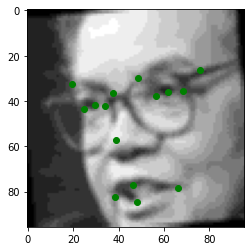

temp device: False
x: [65.17412  31.269943 59.400993 70.94724  37.394943 25.112972 56.762104
 75.64903  38.38643  20.982843 48.75024  60.185192 36.068375 48.11084
 48.942394]
y: [36.488796 38.056797 36.185085 36.792507 37.46494  39.256424 28.428795
 28.508247 30.204329 30.492264 47.508007 67.610275 68.47419  59.662163
 72.807915]


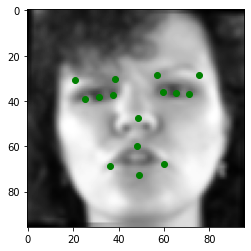

temp device: False
x: [63.846004 29.398375 58.36787  70.31675  34.178535 22.92911  51.484753
 78.007935 38.660736 12.959435 50.32199  64.9167   43.001408 53.25609
 55.769997]
y: [36.700268 41.38024  38.33519  36.696438 42.019398 43.540417 29.419613
 31.097504 30.125162 39.814377 58.706665 79.66035  84.0423   74.41996
 89.45783 ]


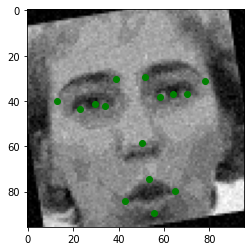

temp device: False
x: [67.01116  27.535648 58.39656  75.35939  36.31849  19.671507 52.845318
 77.34151  39.48114  12.678415 49.1963   69.00899  35.574955 51.890717
 53.56318 ]
y: [35.400913 40.425304 35.46     36.12827  38.494007 42.672577 30.754625
 25.15514  31.869127 35.373455 53.718437 74.492424 79.46196  73.91935
 84.8633  ]


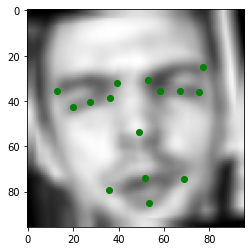

temp device: False
x: [62.949806 30.406178 55.042473 71.274254 37.99228  21.710579 53.862255
 72.27854  37.292885 15.155715 46.336414 63.351353 31.35135  46.89903
 46.94054 ]
y: [36.410812 36.633205 38.73359  36.9747   38.80772  37.51339  29.774664
 28.425753 30.481707 30.372269 57.18716  69.49189  69.9027   71.201294
 72.562164]


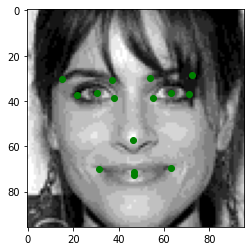

temp device: False
x: [52.31498  20.026976 47.390995 61.55839  30.622087 13.369667 42.86833
 61.23302  28.283945  3.563225 50.0278   69.603546 41.527164 58.24089
 59.0286  ]
y: [16.673126  36.184822  22.867868  13.272625  33.182117  41.23198
 17.885384   1.9882004 24.881384  35.177887  44.683857  52.88586
 68.849205  61.716557  61.90427  ]


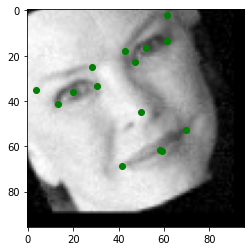

temp device: False
x: [64.719505 30.650679 59.348553 71.688675 37.618477 23.669779 56.98607
 76.818825 38.204185 17.538078 50.14537  64.8014   37.975418 50.88147
 51.87617 ]
y: [36.522823 39.298416 38.104607 37.094837 40.138622 41.14018  28.170868
 30.149193 30.488209 34.1367   54.950813 72.99172  75.26791  68.36175
 83.65143 ]


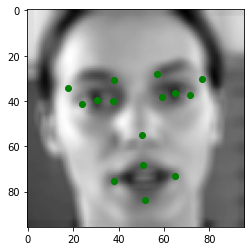

temp device: False
x: [67.96951   29.458393  61.21323   77.7668    35.5389    22.02633
 60.1406    82.83364   36.953197  14.9321575 48.714333  62.56479
 35.87679   47.36277   47.36277  ]
y: [37.667526 35.978683 39.019085 40.370647 37.32964  36.654613 27.72291
 31.24921  27.437328 28.208881 53.545322 78.54388  78.88177  70.436035
 85.97594 ]


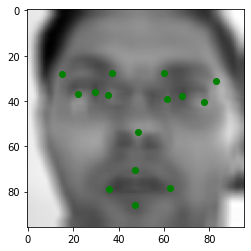

temp device: False
x: [66.7004   30.572386 59.455467 74.2412   38.29013  21.793804 57.537594
 82.74244  39.23005  14.858806 45.403168 62.0982   27.140265 44.26243
 43.20451 ]
y: [39.480965 36.434906 39.757565 41.703625 38.88321  37.27241  27.83914
 33.427967 27.72696  29.59314  55.60603  75.20049  70.941505 73.103676
 79.490265]


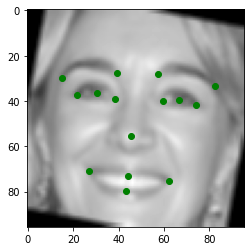

temp device: False
x: [68.22027  32.710598 62.12888  73.54402  38.03435  25.942791 59.69491
 81.92502  48.367607 19.782593 46.37155  50.71901  25.438908 41.604683
 36.2414  ]
y: [44.944645 33.121296 44.849163 48.083946 36.260597 32.8546   34.523552
 44.80029  29.512003 24.468473 57.425247 85.85808  77.69119  73.49051
 91.92317 ]


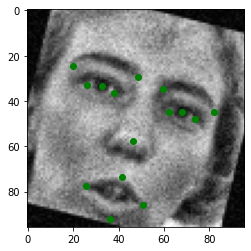

temp device: False
x: [59.548    25.361774 53.695896 65.26797  30.982834 20.121984 48.58234
 68.42029  32.218884 12.287227 46.28663  64.23599  35.852055 48.24792
 50.3542  ]
y: [31.742363 38.246704 33.300526 31.556625 37.399616 39.374542 26.294102
 23.304543 32.141342 35.29226  53.6908   69.58337  74.199005 68.94968
 78.43791 ]


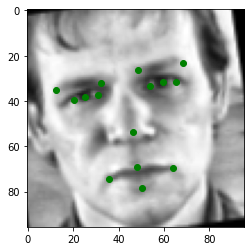

temp device: False
x: [64.47284  26.296854 58.564518 70.57899  32.6357   20.547026 56.62944
 74.21063  33.224125 12.323106 49.672993 67.45762  39.732132 51.924805
 54.64683 ]
y: [32.333942 39.276962 33.7488   32.278923 38.910744 41.781273 22.358074
 22.857468 25.763042 34.917717 54.774643 73.86487  76.23049  68.34257
 83.23196 ]


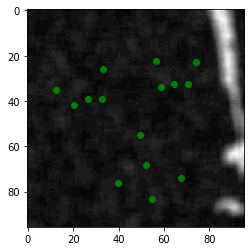

temp device: False
x: [62.633785 27.430458 56.01562  67.6863   33.821968 22.305368 53.819878
 71.26526  34.38221  13.137851 48.468185 67.48852  38.981255 52.059975
 54.486927]
y: [32.711494 40.955265 34.861343 32.233555 40.105637 43.30847  27.740982
 21.961573 32.528187 33.7979   51.80306  69.087135 75.46938  68.43056
 76.41381 ]


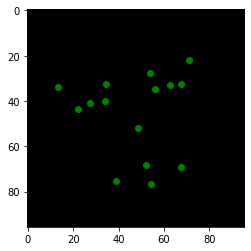

temp device: False
x: [56.630013  23.723705  51.79281   63.045864  30.13956   18.245596
 46.491325  71.01685   32.853973   7.7622876 43.39723   61.058697
 30.737917  45.479485  48.718784 ]
y: [42.094807 46.860603 43.797592 41.896267 46.66206  47.91187  35.004333
 33.65408  36.588703 40.37119  61.931763 79.97132  84.75706  75.47357
 93.69908 ]


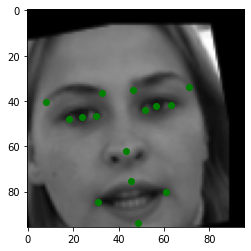

temp device: False
x: [62.879753 23.371696 53.17852  68.73748  30.674961 14.532791 49.987953
 73.39252  32.723537  8.831689 42.40033  59.12374  27.709154 41.86725
 42.031166]
y: [35.20451  36.29464  36.081013 34.887287 34.923733 36.55425  29.70935
 28.986767 31.766426 31.182709 61.410534 77.76128  78.65481  79.70922
 80.807106]


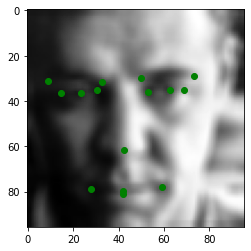

temp device: False
x: [68.19307  28.713991 61.341724 78.02642  35.038307 18.132336 58.497196
 82.48225  40.672897 18.10243  42.635742 57.615257 22.937708 39.28621
 38.746063]
y: [42.686436 34.948727 40.29086  47.69127  36.21838  35.470562 32.472523
 34.984673 27.448225 24.82243  55.299637 76.62392  68.89979  74.40931
 75.147514]


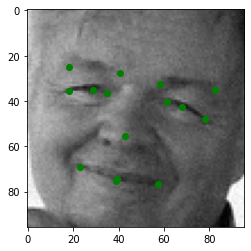

temp device: False
x: [64.18793  29.422325 57.27962  72.95379  36.597874 20.616795 50.527103
 77.94228  40.103615 13.656706 49.15962  67.237495 40.4026   53.538742
 55.293365]
y: [33.81938  38.99726  36.735653 32.185974 39.525047 40.30446  33.349415
 23.693695 35.332066 33.963615 65.09297  77.64399  81.94257  80.6516
 87.403824]


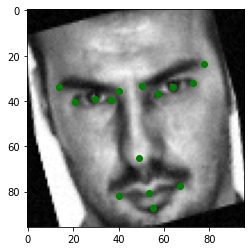

temp device: False
x: [68.59017  33.44806  59.384716 75.30119  39.167667 25.262484 52.955547
 81.4906   40.150562 20.43287  39.250393 57.447594 30.54473  40.855824
 40.912495]
y: [39.76088  40.37223  41.015278 41.53383  41.964207 41.2376   31.722843
 32.838856 31.567892 32.504562 56.10841  81.0546   80.90644  77.6103
 78.90816 ]


KeyboardInterrupt: ignored

In [ ]:
# this is not for implementation but to check if the above lines work
ds = FacialKeypointDataset(csv_file="train_15.csv", train=True, transform=train_transforms)
loader = DataLoader(ds, batch_size=1, shuffle=True, num_workers=0)

for idx, (x, y) in enumerate(loader):
    temp = x[0][0].detach().cpu().numpy()
    print(f"temp device: {temp.flags['OWNDATA']}")
    plt.imshow(temp, cmap='gray')
    print(f"x: {y[0][0::2].detach().cpu().numpy()}")
    print(f"y: {y[0][1::2].detach().cpu().numpy()}")
    plt.plot(y[0][0::2].detach().cpu().numpy(), y[0][1::2].detach().cpu().numpy(), "go")
    plt.show()

3. Training

In [ ]:
# 3. Define the methods for training

from tqdm import tqdm

# get the loss of the validation
def get_rmse(loader, model, loss_fn, device):
    model.eval()
    num_examples = 0
    losses = []
    for batch_idx, (data, targets) in enumerate(loader):
        data = data.to(device=device)
        targets = targets.to(device=device)

        # forward, the loss is defined in train file
        scores = model(data)
        # get loss function w.r.t. those that do not have targets to -1 (i.e., NaN)
        loss = loss_fn(scores[targets != -1], targets[targets != -1])
        num_examples += scores[targets != -1].shape[0]
        losses.append(loss.item())

    model.train()
    print(f"Loss on val: {(sum(losses)/num_examples)**0.5}")


def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer, lr):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

In [ ]:
# 4. training

! pip install efficientnet-pytorch

from torch import nn, optim
from efficientnet_pytorch import EfficientNet

def train_one_epoch(loader, model, optimizer, loss_fn, scaler, device):
    losses = []
    loop = tqdm(loader)
    num_examples = 0
    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=device)
        targets = targets.to(device=device)

        # forward
        scores = model(data)
        scores[targets == -1] = -1
        loss = loss_fn(scores, targets)
        num_examples += torch.numel(scores[targets != -1])
        losses.append(loss.item())

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Loss average over epoch: {(sum(losses)/num_examples)**0.5}")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


3.1 Training for 15-point model

In [ ]:
# to be repeated for [4, 15], No. 1

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

LEARNING_RATE = 1e-4
WEIGHT_DECAY = 5e-4
BATCH_SIZE = 64
NUM_EPOCHS = 200
NUM_WORKERS = 4
CHECKPOINT_FILE = "b0_15.pth.tar" ### 4 or 15 (1)
PIN_MEMORY = True
SAVE_MODEL = True
LOAD_MODEL = True

train_ds = FacialKeypointDataset(
    csv_file="train_15.csv",      ### 4 or 15 (2)
    transform=train_transforms,
    )
train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=True,
    )
val_ds = FacialKeypointDataset(
    transform=val_transforms,
    csv_file="val_15.csv",        ### 4 or 15 (3)
    )
val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=False,
    )

loss_fn = nn.MSELoss(reduction="sum") 
model = EfficientNet.from_pretrained("efficientnet-b0")
model._fc = nn.Linear(1280, 30)
model = model.to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scaler = torch.cuda.amp.GradScaler()

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch}")
    get_rmse(val_loader, model, loss_fn, DEVICE)
    train_one_epoch(train_loader, model, optimizer, loss_fn, scaler, DEVICE)

    # get on validation
    if SAVE_MODEL:
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
        }
        save_checkpoint(checkpoint, filename=CHECKPOINT_FILE)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Loaded pretrained weights for efficientnet-b0
Epoch 0
Loss on val: 50.77217249635867


100%|██████████| 35/35 [00:21<00:00,  1.65it/s]


Loss average over epoch: 50.931279141330585
=> Saving checkpoint
Epoch 1
Loss on val: 50.53877884027934


100%|██████████| 35/35 [00:23<00:00,  1.51it/s]


Loss average over epoch: 49.99225449182263
=> Saving checkpoint
Epoch 2
Loss on val: 40.996062310909814


100%|██████████| 35/35 [00:20<00:00,  1.69it/s]

Loss average over epoch: 48.23324599242831
=> Saving checkpoint
Epoch 3


Loss on val: 18.35964210798602


100%|██████████| 35/35 [00:22<00:00,  1.53it/s]

Loss average over epoch: 46.07380969988698
=> Saving checkpoint
Epoch 4


Loss on val: 18.256199574847628


100%|██████████| 35/35 [00:21<00:00,  1.66it/s]

Loss average over epoch: 44.27416005196031
=> Saving checkpoint
Epoch 5


Loss on val: 18.55641398546605


100%|██████████| 35/35 [00:23<00:00,  1.51it/s]

Loss average over epoch: 42.92498773769563
=> Saving checkpoint
Epoch 6


Loss on val: 15.36220368577807


100%|██████████| 35/35 [00:20<00:00,  1.69it/s]

Loss average over epoch: 41.8124186794094
=> Saving checkpoint
Epoch 7


Loss on val: 14.112857981878323


100%|██████████| 35/35 [00:23<00:00,  1.50it/s]

Loss average over epoch: 40.751503220621125
=> Saving checkpoint
Epoch 8


Loss on val: 15.803360336228073


100%|██████████| 35/35 [00:21<00:00,  1.66it/s]

Loss average over epoch: 39.858810289922985
=> Saving checkpoint
Epoch 9


Loss on val: 19.936052455288134


100%|██████████| 35/35 [00:23<00:00,  1.50it/s]

Loss average over epoch: 38.69745292880367
=> Saving checkpoint
Epoch 10


Loss on val: 20.246938297349224


100%|██████████| 35/35 [00:20<00:00,  1.67it/s]

Loss average over epoch: 36.06938784371155
=> Saving checkpoint
Epoch 11


Loss on val: 24.469214501763915


100%|██████████| 35/35 [00:22<00:00,  1.59it/s]

Loss average over epoch: 30.90357940713397
=> Saving checkpoint
Epoch 12


Loss on val: 16.220184827348096


100%|██████████| 35/35 [00:20<00:00,  1.68it/s]


Loss average over epoch: 28.485011646428774
=> Saving checkpoint
Epoch 13
Loss on val: 14.10923807150242


100%|██████████| 35/35 [00:22<00:00,  1.57it/s]

Loss average over epoch: 26.545390906736
=> Saving checkpoint
Epoch 14


Loss on val: 14.507217672018758


100%|██████████| 35/35 [00:21<00:00,  1.61it/s]


Loss average over epoch: 24.758464667836723
=> Saving checkpoint
Epoch 15
Loss on val: 14.31884902846594


100%|██████████| 35/35 [00:21<00:00,  1.66it/s]

Loss average over epoch: 23.134464104522113
=> Saving checkpoint
Epoch 16


Loss on val: 14.940596262086284


100%|██████████| 35/35 [00:22<00:00,  1.56it/s]


Loss average over epoch: 21.65254194003773
=> Saving checkpoint
Epoch 17
Loss on val: 14.43704490624726


100%|██████████| 35/35 [00:20<00:00,  1.67it/s]

Loss average over epoch: 20.287149618791663
=> Saving checkpoint
Epoch 18


Loss on val: 14.541364132478538


100%|██████████| 35/35 [00:22<00:00,  1.52it/s]

Loss average over epoch: 18.930371331420275
=> Saving checkpoint
Epoch 19


Loss on val: 13.82179589151376


100%|██████████| 35/35 [00:21<00:00,  1.66it/s]

Loss average over epoch: 17.75287102991071
=> Saving checkpoint
Epoch 20


Loss on val: 13.827935945035327


100%|██████████| 35/35 [00:23<00:00,  1.52it/s]

Loss average over epoch: 16.629787591135603
=> Saving checkpoint
Epoch 21


Loss on val: 13.06808532902455


100%|██████████| 35/35 [00:21<00:00,  1.66it/s]

Loss average over epoch: 15.572646073878007
=> Saving checkpoint
Epoch 22


Loss on val: 12.280086352845135


100%|██████████| 35/35 [00:23<00:00,  1.51it/s]

Loss average over epoch: 14.619595561348001
=> Saving checkpoint
Epoch 23


Loss on val: 10.580037954799595


100%|██████████| 35/35 [00:20<00:00,  1.69it/s]

Loss average over epoch: 13.67753622102455
=> Saving checkpoint
Epoch 24


Loss on val: 10.155261362138019


100%|██████████| 35/35 [00:23<00:00,  1.52it/s]

Loss average over epoch: 12.797927997216172
=> Saving checkpoint
Epoch 25


Loss on val: 9.661616362139757


100%|██████████| 35/35 [00:20<00:00,  1.67it/s]

Loss average over epoch: 12.010215096036713
=> Saving checkpoint
Epoch 26


Loss on val: 9.703662860830784


100%|██████████| 35/35 [00:22<00:00,  1.57it/s]

Loss average over epoch: 11.251464782801094
=> Saving checkpoint
Epoch 27


Loss on val: 8.526550140101604


100%|██████████| 35/35 [00:20<00:00,  1.67it/s]


Loss average over epoch: 10.527739754488419
=> Saving checkpoint
Epoch 28
Loss on val: 7.89446931929774


100%|██████████| 35/35 [00:22<00:00,  1.58it/s]

Loss average over epoch: 9.916071163447054
=> Saving checkpoint
Epoch 29


Loss on val: 7.626769859487261


100%|██████████| 35/35 [00:21<00:00,  1.59it/s]


Loss average over epoch: 9.331604494444703
=> Saving checkpoint
Epoch 30
Loss on val: 7.726999977082524


100%|██████████| 35/35 [00:20<00:00,  1.67it/s]

Loss average over epoch: 8.94339882521985
=> Saving checkpoint
Epoch 31


Loss on val: 6.971575100004302


100%|██████████| 35/35 [00:22<00:00,  1.52it/s]


Loss average over epoch: 8.371006187158368
=> Saving checkpoint
Epoch 32
Loss on val: 6.351847356773461


100%|██████████| 35/35 [00:20<00:00,  1.70it/s]

Loss average over epoch: 7.905171439011378
=> Saving checkpoint
Epoch 33


Loss on val: 5.620306606775707


100%|██████████| 35/35 [00:23<00:00,  1.50it/s]

Loss average over epoch: 7.52121354134593
=> Saving checkpoint
Epoch 34


Loss on val: 5.225066661257379


100%|██████████| 35/35 [00:21<00:00,  1.65it/s]

Loss average over epoch: 7.122670208233114
=> Saving checkpoint
Epoch 35


Loss on val: 4.845537774914669


100%|██████████| 35/35 [00:23<00:00,  1.50it/s]

Loss average over epoch: 6.886590415609917
=> Saving checkpoint
Epoch 36


Loss on val: 4.7799268321631585


100%|██████████| 35/35 [00:20<00:00,  1.70it/s]

Loss average over epoch: 6.572440414947846
=> Saving checkpoint
Epoch 37


Loss on val: 4.300544720827041


100%|██████████| 35/35 [00:23<00:00,  1.51it/s]

Loss average over epoch: 6.356712460455067
=> Saving checkpoint
Epoch 38


Loss on val: 4.611499580984115


100%|██████████| 35/35 [00:20<00:00,  1.72it/s]

Loss average over epoch: 6.08952365210784
=> Saving checkpoint
Epoch 39


Loss on val: 4.081818330770818


100%|██████████| 35/35 [00:23<00:00,  1.52it/s]

Loss average over epoch: 5.913704594981105
=> Saving checkpoint
Epoch 40


Loss on val: 3.994384730468511


100%|██████████| 35/35 [00:21<00:00,  1.66it/s]

Loss average over epoch: 5.772367886496929
=> Saving checkpoint
Epoch 41


Loss on val: 3.767517591476294


100%|██████████| 35/35 [00:23<00:00,  1.48it/s]

Loss average over epoch: 5.712653202450815
=> Saving checkpoint
Epoch 42


Loss on val: 3.5115158392898262


100%|██████████| 35/35 [00:21<00:00,  1.66it/s]

Loss average over epoch: 5.521467947386189
=> Saving checkpoint
Epoch 43


Loss on val: 3.3236970250103273


100%|██████████| 35/35 [00:22<00:00,  1.57it/s]

Loss average over epoch: 5.431878386934467
=> Saving checkpoint
Epoch 44


Loss on val: 3.363524181847813


100%|██████████| 35/35 [00:21<00:00,  1.61it/s]


Loss average over epoch: 5.389894088706231
=> Saving checkpoint
Epoch 45
Loss on val: 3.211408699205589


100%|██████████| 35/35 [00:21<00:00,  1.65it/s]

Loss average over epoch: 5.241664208058781
=> Saving checkpoint
Epoch 46


Loss on val: 3.0830970841360696


100%|██████████| 35/35 [00:22<00:00,  1.55it/s]


Loss average over epoch: 5.2185691510855
=> Saving checkpoint
Epoch 47
Loss on val: 3.03091380223234


100%|██████████| 35/35 [00:20<00:00,  1.69it/s]

Loss average over epoch: 5.259548876818504
=> Saving checkpoint
Epoch 48


Loss on val: 2.9918075531183206


100%|██████████| 35/35 [00:23<00:00,  1.52it/s]

Loss average over epoch: 5.203768416385535
=> Saving checkpoint
Epoch 49


Loss on val: 2.961439134068378


100%|██████████| 35/35 [00:20<00:00,  1.67it/s]

Loss average over epoch: 5.119571804840772
=> Saving checkpoint
Epoch 50


Loss on val: 2.9282935850615286


100%|██████████| 35/35 [00:23<00:00,  1.52it/s]

Loss average over epoch: 5.0408669702858635
=> Saving checkpoint
Epoch 51


Loss on val: 2.923174677523138


100%|██████████| 35/35 [00:20<00:00,  1.70it/s]

Loss average over epoch: 5.053800242235751
=> Saving checkpoint
Epoch 52


Loss on val: 3.119435201532883


100%|██████████| 35/35 [00:22<00:00,  1.52it/s]

Loss average over epoch: 5.128100043756084
=> Saving checkpoint
Epoch 53


Loss on val: 3.2413172275776505


100%|██████████| 35/35 [00:20<00:00,  1.69it/s]

Loss average over epoch: 5.069597417987379
=> Saving checkpoint
Epoch 54


Loss on val: 3.2455301794673446


100%|██████████| 35/35 [00:22<00:00,  1.53it/s]

Loss average over epoch: 5.084227868797663
=> Saving checkpoint
Epoch 55


Loss on val: 2.835633047248151


100%|██████████| 35/35 [00:20<00:00,  1.68it/s]


Loss average over epoch: 5.005950741947056
=> Saving checkpoint
Epoch 56
Loss on val: 2.877634153312839


100%|██████████| 35/35 [00:23<00:00,  1.51it/s]

Loss average over epoch: 5.050545227685163
=> Saving checkpoint
Epoch 57


Loss on val: 3.038376609618202


100%|██████████| 35/35 [00:20<00:00,  1.70it/s]

Loss average over epoch: 5.021946918382822
=> Saving checkpoint
Epoch 58


Loss on val: 2.813037911523175


100%|██████████| 35/35 [00:23<00:00,  1.50it/s]

Loss average over epoch: 5.038244981102911
=> Saving checkpoint
Epoch 59


Loss on val: 2.9358804267558876


100%|██████████| 35/35 [00:20<00:00,  1.70it/s]

Loss average over epoch: 5.061587053377101
=> Saving checkpoint
Epoch 60


Loss on val: 3.584020616017947


100%|██████████| 35/35 [00:22<00:00,  1.56it/s]

Loss average over epoch: 4.9622424048916205
=> Saving checkpoint
Epoch 61


Loss on val: 3.749051963496905


100%|██████████| 35/35 [00:21<00:00,  1.66it/s]


Loss average over epoch: 5.020402930030642
=> Saving checkpoint
Epoch 62
Loss on val: 3.6047600366563928


100%|██████████| 35/35 [00:21<00:00,  1.60it/s]


Loss average over epoch: 5.0847637857789
=> Saving checkpoint
Epoch 63
Loss on val: 2.984290247487667


100%|██████████| 35/35 [00:20<00:00,  1.69it/s]


Loss average over epoch: 4.991801475338404
=> Saving checkpoint
Epoch 64
Loss on val: 2.8788731270708743


100%|██████████| 35/35 [00:21<00:00,  1.63it/s]

Loss average over epoch: 5.038330223701325
=> Saving checkpoint
Epoch 65


Loss on val: 3.037278744942447


100%|██████████| 35/35 [00:22<00:00,  1.59it/s]


Loss average over epoch: 5.100119459569839
=> Saving checkpoint
Epoch 66
Loss on val: 3.2178773088792556


100%|██████████| 35/35 [00:20<00:00,  1.68it/s]

Loss average over epoch: 4.992625095242847
=> Saving checkpoint
Epoch 67


Loss on val: 2.974541937775182


100%|██████████| 35/35 [00:22<00:00,  1.54it/s]


Loss average over epoch: 5.021316322656186
=> Saving checkpoint
Epoch 68
Loss on val: 2.8594207077403224


100%|██████████| 35/35 [00:20<00:00,  1.72it/s]

Loss average over epoch: 5.004801241847202
=> Saving checkpoint
Epoch 69


Loss on val: 2.917490471456876


100%|██████████| 35/35 [00:22<00:00,  1.53it/s]


Loss average over epoch: 4.949430383928008
=> Saving checkpoint
Epoch 70
Loss on val: 2.7625414778183273


100%|██████████| 35/35 [00:21<00:00,  1.65it/s]

Loss average over epoch: 5.097472112857999
=> Saving checkpoint
Epoch 71


Loss on val: 2.8014093830159847


100%|██████████| 35/35 [00:23<00:00,  1.51it/s]

Loss average over epoch: 5.0169899824066055
=> Saving checkpoint
Epoch 72


Loss on val: 2.8287199535339007


100%|██████████| 35/35 [00:20<00:00,  1.68it/s]

Loss average over epoch: 4.9774770898566265
=> Saving checkpoint
Epoch 73


Loss on val: 2.8031110646253388


100%|██████████| 35/35 [00:23<00:00,  1.48it/s]

Loss average over epoch: 4.978683089682407
=> Saving checkpoint
Epoch 74


Loss on val: 3.0459638594923173


100%|██████████| 35/35 [00:21<00:00,  1.66it/s]

Loss average over epoch: 5.006267783234806
=> Saving checkpoint
Epoch 75


Loss on val: 2.8132896460927195


100%|██████████| 35/35 [00:22<00:00,  1.53it/s]

Loss average over epoch: 5.04771792489581
=> Saving checkpoint
Epoch 76


Loss on val: 2.7971346480967507


100%|██████████| 35/35 [00:20<00:00,  1.68it/s]


Loss average over epoch: 5.080616161009537
=> Saving checkpoint
Epoch 77
Loss on val: 2.888199207370976


100%|██████████| 35/35 [00:22<00:00,  1.58it/s]

Loss average over epoch: 5.045513771615634
=> Saving checkpoint
Epoch 78


Loss on val: 2.8081892890852878


100%|██████████| 35/35 [00:21<00:00,  1.63it/s]


Loss average over epoch: 4.978946932935611
=> Saving checkpoint
Epoch 79
Loss on val: 2.930409660994517


100%|██████████| 35/35 [00:21<00:00,  1.65it/s]

Loss average over epoch: 4.958187732881311
=> Saving checkpoint
Epoch 80


Loss on val: 2.978396662583327


100%|██████████| 35/35 [00:22<00:00,  1.58it/s]


Loss average over epoch: 4.98527312802169
=> Saving checkpoint
Epoch 81
Loss on val: 3.3135390469443693


100%|██████████| 35/35 [00:21<00:00,  1.64it/s]

Loss average over epoch: 5.001958095105649
=> Saving checkpoint
Epoch 82


Loss on val: 3.81850065675325


100%|██████████| 35/35 [00:22<00:00,  1.53it/s]

Loss average over epoch: 4.954095478680657
=> Saving checkpoint
Epoch 83


Loss on val: 4.297815578872597


100%|██████████| 35/35 [00:20<00:00,  1.71it/s]

Loss average over epoch: 4.924450996921936
=> Saving checkpoint
Epoch 84


Loss on val: 4.275248150083415


100%|██████████| 35/35 [00:22<00:00,  1.54it/s]

Loss average over epoch: 4.878437664019307
=> Saving checkpoint
Epoch 85


Loss on val: 5.936195799745547


100%|██████████| 35/35 [00:20<00:00,  1.72it/s]

Loss average over epoch: 4.747822901719888
=> Saving checkpoint
Epoch 86


Loss on val: 6.128207493495413


100%|██████████| 35/35 [00:22<00:00,  1.55it/s]

Loss average over epoch: 4.665736967516228
=> Saving checkpoint
Epoch 87


Loss on val: 8.207342050972816


100%|██████████| 35/35 [00:20<00:00,  1.70it/s]

Loss average over epoch: 4.611906976766529
=> Saving checkpoint
Epoch 88


Loss on val: 9.415700816986487


100%|██████████| 35/35 [00:22<00:00,  1.53it/s]

Loss average over epoch: 4.371859866789989
=> Saving checkpoint
Epoch 89


Loss on val: 9.891305235955128


100%|██████████| 35/35 [00:20<00:00,  1.72it/s]

Loss average over epoch: 4.291796850178094
=> Saving checkpoint
Epoch 90


Loss on val: 9.725337397746157


100%|██████████| 35/35 [00:22<00:00,  1.53it/s]

Loss average over epoch: 4.181173368472103
=> Saving checkpoint
Epoch 91


Loss on val: 8.432056423010541


100%|██████████| 35/35 [00:20<00:00,  1.70it/s]

Loss average over epoch: 4.148741873683387
=> Saving checkpoint
Epoch 92


Loss on val: 8.57515640042015


100%|██████████| 35/35 [00:22<00:00,  1.54it/s]


Loss average over epoch: 4.103160010939112
=> Saving checkpoint
Epoch 93
Loss on val: 5.916126552518689


100%|██████████| 35/35 [00:20<00:00,  1.72it/s]

Loss average over epoch: 4.061059115936441
=> Saving checkpoint
Epoch 94


Loss on val: 5.671620575101676


100%|██████████| 35/35 [00:23<00:00,  1.52it/s]

Loss average over epoch: 3.9667772366661036
=> Saving checkpoint
Epoch 95


Loss on val: 4.96572615011306


100%|██████████| 35/35 [00:20<00:00,  1.71it/s]

Loss average over epoch: 3.961974174705616
=> Saving checkpoint
Epoch 96


Loss on val: 4.505209152215725


100%|██████████| 35/35 [00:22<00:00,  1.55it/s]

Loss average over epoch: 3.958280898316543
=> Saving checkpoint
Epoch 97


Loss on val: 4.834602114359223


100%|██████████| 35/35 [00:20<00:00,  1.72it/s]

Loss average over epoch: 3.875582028757058
=> Saving checkpoint
Epoch 98


Loss on val: 3.9399962325489604


100%|██████████| 35/35 [00:22<00:00,  1.54it/s]

Loss average over epoch: 3.9658734291760394
=> Saving checkpoint
Epoch 99


Loss on val: 3.87493565134743


100%|██████████| 35/35 [00:20<00:00,  1.73it/s]

Loss average over epoch: 3.8404229576284536
=> Saving checkpoint
Epoch 100


Loss on val: 3.3172366880871893


100%|██████████| 35/35 [00:23<00:00,  1.50it/s]

Loss average over epoch: 3.8996790753110204
=> Saving checkpoint
Epoch 101


Loss on val: 2.913036654778538


100%|██████████| 35/35 [00:20<00:00,  1.72it/s]

Loss average over epoch: 3.838455825441039
=> Saving checkpoint
Epoch 102


Loss on val: 3.318418798209849


100%|██████████| 35/35 [00:22<00:00,  1.53it/s]

Loss average over epoch: 3.8087041876713177
=> Saving checkpoint
Epoch 103


Loss on val: 2.6240594173000034


100%|██████████| 35/35 [00:20<00:00,  1.68it/s]

Loss average over epoch: 3.7960049691944096
=> Saving checkpoint
Epoch 104


Loss on val: 2.47708889647539


100%|██████████| 35/35 [00:22<00:00,  1.55it/s]

Loss average over epoch: 3.8141243944709022
=> Saving checkpoint
Epoch 105


Loss on val: 2.639620740987235


100%|██████████| 35/35 [00:20<00:00,  1.70it/s]

Loss average over epoch: 3.8010668382339943
=> Saving checkpoint
Epoch 106


Loss on val: 2.7006680789976145


100%|██████████| 35/35 [00:22<00:00,  1.52it/s]

Loss average over epoch: 3.797518944335324
=> Saving checkpoint
Epoch 107


Loss on val: 2.518699596269869


100%|██████████| 35/35 [00:20<00:00,  1.70it/s]

Loss average over epoch: 3.759742258071186
=> Saving checkpoint
Epoch 108


Loss on val: 2.4929703250674016


100%|██████████| 35/35 [00:22<00:00,  1.53it/s]

Loss average over epoch: 3.700025483179291
=> Saving checkpoint
Epoch 109


Loss on val: 2.4835529955631777


100%|██████████| 35/35 [00:20<00:00,  1.70it/s]

Loss average over epoch: 3.7961423284831444
=> Saving checkpoint
Epoch 110


Loss on val: 2.547592115299759


100%|██████████| 35/35 [00:22<00:00,  1.55it/s]

Loss average over epoch: 3.8147098722386965
=> Saving checkpoint
Epoch 111


Loss on val: 2.407753791464671


100%|██████████| 35/35 [00:20<00:00,  1.70it/s]

Loss average over epoch: 3.7431567902553757
=> Saving checkpoint
Epoch 112


Loss on val: 2.4713764707458576


100%|██████████| 35/35 [00:22<00:00,  1.54it/s]

Loss average over epoch: 3.7586738879303057
=> Saving checkpoint
Epoch 113


Loss on val: 2.6484501290259366


100%|██████████| 35/35 [00:20<00:00,  1.70it/s]

Loss average over epoch: 3.694944492281598
=> Saving checkpoint
Epoch 114


Loss on val: 2.6281251857907186


100%|██████████| 35/35 [00:22<00:00,  1.54it/s]

Loss average over epoch: 3.7484005055913148
=> Saving checkpoint
Epoch 115


Loss on val: 3.297581677817094


100%|██████████| 35/35 [00:20<00:00,  1.67it/s]

Loss average over epoch: 3.769190648920247
=> Saving checkpoint
Epoch 116


Loss on val: 3.6003060217877083


100%|██████████| 35/35 [00:22<00:00,  1.57it/s]

Loss average over epoch: 3.71961800871683
=> Saving checkpoint
Epoch 117


Loss on val: 3.688854668189143


100%|██████████| 35/35 [00:20<00:00,  1.69it/s]


Loss average over epoch: 3.68184601610899
=> Saving checkpoint
Epoch 118
Loss on val: 4.526744311588628


100%|██████████| 35/35 [00:22<00:00,  1.59it/s]

Loss average over epoch: 3.6732851434336418
=> Saving checkpoint
Epoch 119


Loss on val: 4.811083530721882


100%|██████████| 35/35 [00:21<00:00,  1.62it/s]


Loss average over epoch: 3.6387230610087933
=> Saving checkpoint
Epoch 120
Loss on val: 4.695348013592816


100%|██████████| 35/35 [00:20<00:00,  1.69it/s]

Loss average over epoch: 3.5913240329463574
=> Saving checkpoint
Epoch 121


Loss on val: 5.795018402149384


100%|██████████| 35/35 [00:22<00:00,  1.52it/s]


Loss average over epoch: 3.4653568959760594
=> Saving checkpoint
Epoch 122
Loss on val: 6.363431701592572


100%|██████████| 35/35 [00:20<00:00,  1.69it/s]

Loss average over epoch: 3.4740859443934826
=> Saving checkpoint
Epoch 123


Loss on val: 6.239964860344434


100%|██████████| 35/35 [00:22<00:00,  1.54it/s]

Loss average over epoch: 3.4413003540304508
=> Saving checkpoint
Epoch 124


Loss on val: 4.843075490670503


100%|██████████| 35/35 [00:20<00:00,  1.71it/s]

Loss average over epoch: 3.3404725626976686
=> Saving checkpoint
Epoch 125


Loss on val: 5.434263883759541


100%|██████████| 35/35 [00:22<00:00,  1.55it/s]

Loss average over epoch: 3.311891863490794
=> Saving checkpoint
Epoch 126


Loss on val: 5.691119727259303


100%|██████████| 35/35 [00:20<00:00,  1.70it/s]

Loss average over epoch: 3.2879263185599803
=> Saving checkpoint
Epoch 127


Loss on val: 4.483295819623104


100%|██████████| 35/35 [00:22<00:00,  1.53it/s]


Loss average over epoch: 3.2244091149174623
=> Saving checkpoint
Epoch 128
Loss on val: 4.479618993633833


100%|██████████| 35/35 [00:20<00:00,  1.70it/s]

Loss average over epoch: 3.2369417557655207
=> Saving checkpoint
Epoch 129


Loss on val: 5.6231591895333475


100%|██████████| 35/35 [00:23<00:00,  1.51it/s]

Loss average over epoch: 3.1854444696808994
=> Saving checkpoint
Epoch 130


Loss on val: 4.641460292390029


100%|██████████| 35/35 [00:20<00:00,  1.68it/s]

Loss average over epoch: 3.1805496314053725
=> Saving checkpoint
Epoch 131


Loss on val: 4.6898932085167635


100%|██████████| 35/35 [00:23<00:00,  1.52it/s]

Loss average over epoch: 3.092114668759206
=> Saving checkpoint
Epoch 132


Loss on val: 5.460274801826217


100%|██████████| 35/35 [00:20<00:00,  1.71it/s]

Loss average over epoch: 3.0716981781109696
=> Saving checkpoint
Epoch 133


Loss on val: 4.69452487500954


100%|██████████| 35/35 [00:23<00:00,  1.49it/s]

Loss average over epoch: 3.0123249289101914
=> Saving checkpoint
Epoch 134


Loss on val: 3.721667141900813


100%|██████████| 35/35 [00:20<00:00,  1.68it/s]

Loss average over epoch: 3.046594313849239
=> Saving checkpoint
Epoch 135


Loss on val: 4.575084883661541


100%|██████████| 35/35 [00:22<00:00,  1.58it/s]

Loss average over epoch: 2.9954560296897617
=> Saving checkpoint
Epoch 136


Loss on val: 4.628071193137591


100%|██████████| 35/35 [00:21<00:00,  1.64it/s]


Loss average over epoch: 2.9894726693165716
=> Saving checkpoint
Epoch 137
Loss on val: 3.699047729019254


100%|██████████| 35/35 [00:21<00:00,  1.66it/s]

Loss average over epoch: 2.9547629263520863
=> Saving checkpoint
Epoch 138


Loss on val: 3.1339351947172585


100%|██████████| 35/35 [00:21<00:00,  1.62it/s]


Loss average over epoch: 2.9045830815674467
=> Saving checkpoint
Epoch 139
Loss on val: 4.17281052244767


100%|██████████| 35/35 [00:20<00:00,  1.69it/s]

Loss average over epoch: 2.8691079515061135
=> Saving checkpoint
Epoch 140


Loss on val: 2.469762121115277


100%|██████████| 35/35 [00:22<00:00,  1.54it/s]


Loss average over epoch: 2.8417458483324403
=> Saving checkpoint
Epoch 141
Loss on val: 2.7612526937609463


100%|██████████| 35/35 [00:20<00:00,  1.69it/s]

Loss average over epoch: 2.8535676238376486
=> Saving checkpoint
Epoch 142


Loss on val: 1.9808934353173402


100%|██████████| 35/35 [00:23<00:00,  1.50it/s]

Loss average over epoch: 2.88936067518118
=> Saving checkpoint
Epoch 143


Loss on val: 3.260608187931867


100%|██████████| 35/35 [00:20<00:00,  1.69it/s]

Loss average over epoch: 2.865001189426179
=> Saving checkpoint
Epoch 144


Loss on val: 2.0599431357822113


100%|██████████| 35/35 [00:22<00:00,  1.53it/s]

Loss average over epoch: 2.8252946241553434
=> Saving checkpoint
Epoch 145


Loss on val: 2.4930795817184115


100%|██████████| 35/35 [00:20<00:00,  1.69it/s]

Loss average over epoch: 2.797240384675464
=> Saving checkpoint
Epoch 146


Loss on val: 4.262127916311288


100%|██████████| 35/35 [00:23<00:00,  1.52it/s]

Loss average over epoch: 2.798037433920937
=> Saving checkpoint
Epoch 147


Loss on val: 2.186726760658782


100%|██████████| 35/35 [00:20<00:00,  1.70it/s]

Loss average over epoch: 2.749459979686464
=> Saving checkpoint
Epoch 148


Loss on val: 1.968337630424148


100%|██████████| 35/35 [00:23<00:00,  1.52it/s]

Loss average over epoch: 2.789838952535558
=> Saving checkpoint
Epoch 149


Loss on val: 2.5626423994986762


100%|██████████| 35/35 [00:20<00:00,  1.69it/s]

Loss average over epoch: 2.745477928640124
=> Saving checkpoint
Epoch 150


Loss on val: 2.6722761638411052


100%|██████████| 35/35 [00:23<00:00,  1.51it/s]

Loss average over epoch: 2.692962966387489
=> Saving checkpoint
Epoch 151


Loss on val: 2.3193560037509156


100%|██████████| 35/35 [00:20<00:00,  1.69it/s]

Loss average over epoch: 2.7278614434994104
=> Saving checkpoint
Epoch 152


Loss on val: 2.808117476712973


100%|██████████| 35/35 [00:22<00:00,  1.57it/s]

Loss average over epoch: 2.7010523408472302
=> Saving checkpoint
Epoch 153


Loss on val: 1.7554562448560678


100%|██████████| 35/35 [00:20<00:00,  1.73it/s]


Loss average over epoch: 2.681524163096109
=> Saving checkpoint
Epoch 154
Loss on val: 2.277510741090204


100%|██████████| 35/35 [00:21<00:00,  1.60it/s]

Loss average over epoch: 2.6666659453596484
=> Saving checkpoint
Epoch 155


Loss on val: 1.9623247085329047


100%|██████████| 35/35 [00:20<00:00,  1.67it/s]


Loss average over epoch: 2.6674212790192
=> Saving checkpoint
Epoch 156
Loss on val: 1.7937990202723961


100%|██████████| 35/35 [00:20<00:00,  1.67it/s]

Loss average over epoch: 2.6635689490011143
=> Saving checkpoint
Epoch 157


Loss on val: 3.1594054977097086


100%|██████████| 35/35 [00:21<00:00,  1.61it/s]


Loss average over epoch: 2.61994360557856
=> Saving checkpoint
Epoch 158
Loss on val: 1.891846454607905


100%|██████████| 35/35 [00:20<00:00,  1.70it/s]

Loss average over epoch: 2.6283196979960457
=> Saving checkpoint
Epoch 159


Loss on val: 3.1147314624752696


100%|██████████| 35/35 [00:22<00:00,  1.57it/s]


Loss average over epoch: 2.6374137151658124
=> Saving checkpoint
Epoch 160
Loss on val: 3.119682924509984


100%|██████████| 35/35 [00:20<00:00,  1.69it/s]

Loss average over epoch: 2.5805592443722567
=> Saving checkpoint
Epoch 161


Loss on val: 2.1098662236669967


100%|██████████| 35/35 [00:23<00:00,  1.50it/s]

Loss average over epoch: 2.6609130904976586
=> Saving checkpoint
Epoch 162


Loss on val: 2.7228914816483845


100%|██████████| 35/35 [00:20<00:00,  1.71it/s]


Loss average over epoch: 2.621977363543393
=> Saving checkpoint
Epoch 163
Loss on val: 2.0947448274019163


100%|██████████| 35/35 [00:23<00:00,  1.50it/s]

Loss average over epoch: 2.6030340996307375
=> Saving checkpoint
Epoch 164


Loss on val: 2.5911965970739272


100%|██████████| 35/35 [00:20<00:00,  1.70it/s]

Loss average over epoch: 2.586855177288326
=> Saving checkpoint
Epoch 165


Loss on val: 1.977001268822831


100%|██████████| 35/35 [00:22<00:00,  1.54it/s]

Loss average over epoch: 2.555679017765607
=> Saving checkpoint
Epoch 166


Loss on val: 1.7099780890713678


100%|██████████| 35/35 [00:21<00:00,  1.65it/s]

Loss average over epoch: 2.5380864403353014
=> Saving checkpoint
Epoch 167


Loss on val: 1.649146766844525


100%|██████████| 35/35 [00:22<00:00,  1.55it/s]

Loss average over epoch: 2.5248300485140325
=> Saving checkpoint
Epoch 168


Loss on val: 1.773139383900652


100%|██████████| 35/35 [00:21<00:00,  1.61it/s]


Loss average over epoch: 2.525186572410894
=> Saving checkpoint
Epoch 169
Loss on val: 2.0948513505711053


100%|██████████| 35/35 [00:21<00:00,  1.63it/s]

Loss average over epoch: 2.5228624391454972
=> Saving checkpoint
Epoch 170


Loss on val: 2.0672263160880773


100%|██████████| 35/35 [00:22<00:00,  1.54it/s]


Loss average over epoch: 2.4978419355290566
=> Saving checkpoint
Epoch 171
Loss on val: 1.6443941822332322


100%|██████████| 35/35 [00:20<00:00,  1.67it/s]

Loss average over epoch: 2.4997038686502053
=> Saving checkpoint
Epoch 172


Loss on val: 1.8735698104515393


100%|██████████| 35/35 [00:23<00:00,  1.49it/s]

Loss average over epoch: 2.499563578674562
=> Saving checkpoint
Epoch 173


Loss on val: 2.665101123296419


100%|██████████| 35/35 [00:21<00:00,  1.66it/s]

Loss average over epoch: 2.5319058046338503
=> Saving checkpoint
Epoch 174


Loss on val: 1.86937589678737


100%|██████████| 35/35 [00:23<00:00,  1.50it/s]

Loss average over epoch: 2.5139867967831258
=> Saving checkpoint
Epoch 175


Loss on val: 1.6870959682216016


100%|██████████| 35/35 [00:21<00:00,  1.64it/s]

Loss average over epoch: 2.5150209740202216
=> Saving checkpoint
Epoch 176


Loss on val: 1.8696201029693393


100%|██████████| 35/35 [00:23<00:00,  1.51it/s]

Loss average over epoch: 2.5148943035547298
=> Saving checkpoint
Epoch 177


Loss on val: 1.8935607802194827


100%|██████████| 35/35 [00:20<00:00,  1.68it/s]

Loss average over epoch: 2.492426646781504
=> Saving checkpoint
Epoch 178


Loss on val: 3.234613316501938


100%|██████████| 35/35 [00:23<00:00,  1.52it/s]

Loss average over epoch: 2.5274972538473124
=> Saving checkpoint
Epoch 179


Loss on val: 1.9419472230024901


100%|██████████| 35/35 [00:21<00:00,  1.60it/s]


Loss average over epoch: 2.455222453608874
=> Saving checkpoint
Epoch 180
Loss on val: 1.740746998829035


100%|██████████| 35/35 [00:21<00:00,  1.63it/s]

Loss average over epoch: 2.4300999830364325
=> Saving checkpoint
Epoch 181


Loss on val: 1.8264389259952343


100%|██████████| 35/35 [00:23<00:00,  1.52it/s]


Loss average over epoch: 2.4885644092745993
=> Saving checkpoint
Epoch 182
Loss on val: 1.8585492301484554


100%|██████████| 35/35 [00:21<00:00,  1.65it/s]

Loss average over epoch: 2.4575377293310248
=> Saving checkpoint
Epoch 183


Loss on val: 2.240808845897875


100%|██████████| 35/35 [00:23<00:00,  1.49it/s]

Loss average over epoch: 2.461762321335957
=> Saving checkpoint
Epoch 184


Loss on val: 1.6067799668838192


100%|██████████| 35/35 [00:21<00:00,  1.64it/s]

Loss average over epoch: 2.4873151398317526
=> Saving checkpoint
Epoch 185


Loss on val: 1.531720245608607


100%|██████████| 35/35 [00:23<00:00,  1.50it/s]

Loss average over epoch: 2.3999356204736926
=> Saving checkpoint
Epoch 186


Loss on val: 1.4709498707078419


100%|██████████| 35/35 [00:21<00:00,  1.64it/s]

Loss average over epoch: 2.4345922362378523
=> Saving checkpoint
Epoch 187


Loss on val: 2.066214694571331


100%|██████████| 35/35 [00:23<00:00,  1.52it/s]

Loss average over epoch: 2.4512259014468127
=> Saving checkpoint
Epoch 188


Loss on val: 1.9713114537424699


100%|██████████| 35/35 [00:21<00:00,  1.65it/s]


Loss average over epoch: 2.421986949403425
=> Saving checkpoint
Epoch 189
Loss on val: 2.8641697618121675


100%|██████████| 35/35 [00:21<00:00,  1.63it/s]

Loss average over epoch: 2.459442194355209
=> Saving checkpoint
Epoch 190


Loss on val: 2.815082437088507


100%|██████████| 35/35 [00:22<00:00,  1.53it/s]


Loss average over epoch: 2.430065427461815
=> Saving checkpoint
Epoch 191
Loss on val: 2.943267609095374


100%|██████████| 35/35 [00:20<00:00,  1.67it/s]

Loss average over epoch: 2.431311086988598
=> Saving checkpoint
Epoch 192


Loss on val: 1.635095543048122


100%|██████████| 35/35 [00:23<00:00,  1.50it/s]

Loss average over epoch: 2.366539926455525
=> Saving checkpoint
Epoch 193


Loss on val: 1.941389451218401


100%|██████████| 35/35 [00:21<00:00,  1.64it/s]

Loss average over epoch: 2.3852886102766786
=> Saving checkpoint
Epoch 194


Loss on val: 2.2063017876358164


100%|██████████| 35/35 [00:23<00:00,  1.48it/s]

Loss average over epoch: 2.405193445820667
=> Saving checkpoint
Epoch 195


Loss on val: 1.6628584258833492


100%|██████████| 35/35 [00:21<00:00,  1.64it/s]

Loss average over epoch: 2.346396523712599
=> Saving checkpoint
Epoch 196


Loss on val: 2.2405016164889466


100%|██████████| 35/35 [00:23<00:00,  1.46it/s]

Loss average over epoch: 2.336442139123584
=> Saving checkpoint
Epoch 197


Loss on val: 2.49561526288901


100%|██████████| 35/35 [00:22<00:00,  1.59it/s]


Loss average over epoch: 2.3538086194906307
=> Saving checkpoint
Epoch 198
Loss on val: 2.2204780535862843


100%|██████████| 35/35 [00:21<00:00,  1.62it/s]


Loss average over epoch: 2.3947366762155364
=> Saving checkpoint
Epoch 199
Loss on val: 1.5417898317918257


100%|██████████| 35/35 [00:23<00:00,  1.47it/s]

Loss average over epoch: 2.340479806523341
=> Saving checkpoint


In [ ]:
# Perhaps DON'T DO IT

# to be repeated for [4, 15], No. 2

# Improve the model with lower lr

LEARNING_RATE = 1e-5

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch}")
    get_rmse(val_loader, model, loss_fn, DEVICE)
    train_one_epoch(train_loader, model, optimizer, loss_fn, scaler, DEVICE)

    # get on validation
    if SAVE_MODEL:
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
        }
        save_checkpoint(checkpoint, filename=CHECKPOINT_FILE)

# !mv /content/b0_15.pth.tar /content/drive/MyDrive/FacialKeypointsDetection/

Epoch 0
Loss on val: 2.2045545746013713


100%|██████████| 35/35 [00:21<00:00,  1.65it/s]

Loss average over epoch: 2.3398347858505986
=> Saving checkpoint
Epoch 1


Loss on val: 1.9236205233800012


100%|██████████| 35/35 [00:22<00:00,  1.54it/s]

Loss average over epoch: 2.3291905503343453
=> Saving checkpoint
Epoch 2


Loss on val: 1.9074304319855504


100%|██████████| 35/35 [00:20<00:00,  1.67it/s]


Loss average over epoch: 2.3566020058752826
=> Saving checkpoint
Epoch 3
Loss on val: 1.6496284205181633


100%|██████████| 35/35 [00:21<00:00,  1.60it/s]

Loss average over epoch: 2.342509532670363
=> Saving checkpoint
Epoch 4


Loss on val: 1.6519930552782298


100%|██████████| 35/35 [00:21<00:00,  1.60it/s]


Loss average over epoch: 2.3065551266300224
=> Saving checkpoint
Epoch 5
Loss on val: 1.8869814236576805


100%|██████████| 35/35 [00:20<00:00,  1.67it/s]

Loss average over epoch: 2.282423787143296
=> Saving checkpoint
Epoch 6


Loss on val: 1.3525834595225383


100%|██████████| 35/35 [00:23<00:00,  1.49it/s]


Loss average over epoch: 2.3330613639684863
=> Saving checkpoint
Epoch 7
Loss on val: 2.79293647271559


100%|██████████| 35/35 [00:21<00:00,  1.65it/s]

Loss average over epoch: 2.2579187375447254
=> Saving checkpoint
Epoch 8


Loss on val: 1.743647977152833


100%|██████████| 35/35 [00:23<00:00,  1.49it/s]

Loss average over epoch: 2.2585105356366486
=> Saving checkpoint
Epoch 9


Loss on val: 1.7381744232155854


100%|██████████| 35/35 [00:20<00:00,  1.67it/s]

Loss average over epoch: 2.2451553734626444
=> Saving checkpoint
Epoch 10


Loss on val: 1.6439611417783218


100%|██████████| 35/35 [00:23<00:00,  1.49it/s]

Loss average over epoch: 2.271859392735766
=> Saving checkpoint
Epoch 11


Loss on val: 1.4574608811395535


100%|██████████| 35/35 [00:21<00:00,  1.62it/s]


Loss average over epoch: 2.2610415031487836
=> Saving checkpoint
Epoch 12
Loss on val: 1.8028603891267598


100%|██████████| 35/35 [00:22<00:00,  1.59it/s]

Loss average over epoch: 2.269423777497697
=> Saving checkpoint
Epoch 13


Loss on val: 1.5927421496709822


100%|██████████| 35/35 [00:23<00:00,  1.50it/s]


Loss average over epoch: 2.258802682772285
=> Saving checkpoint
Epoch 14
Loss on val: 2.26380012713689


100%|██████████| 35/35 [00:21<00:00,  1.64it/s]

Loss average over epoch: 2.2133726132923113
=> Saving checkpoint
Epoch 15


Loss on val: 1.9665532552486766


100%|██████████| 35/35 [00:23<00:00,  1.48it/s]

Loss average over epoch: 2.2572127148920895
=> Saving checkpoint
Epoch 16


Loss on val: 2.0510248168852483


100%|██████████| 35/35 [00:21<00:00,  1.62it/s]

Loss average over epoch: 2.2146178608824227
=> Saving checkpoint
Epoch 17


Loss on val: 2.3283568117254565


100%|██████████| 35/35 [00:23<00:00,  1.50it/s]

Loss average over epoch: 2.2397023578670825
=> Saving checkpoint
Epoch 18


Loss on val: 1.938367497325391


100%|██████████| 35/35 [00:21<00:00,  1.66it/s]

Loss average over epoch: 2.215198728639755
=> Saving checkpoint
Epoch 19


Loss on val: 2.6931289162190137


100%|██████████| 35/35 [00:22<00:00,  1.54it/s]

Loss average over epoch: 2.2149157573756084
=> Saving checkpoint
Epoch 20


Loss on val: 2.6375972224873374


100%|██████████| 35/35 [00:21<00:00,  1.66it/s]


Loss average over epoch: 2.1945440121192017
=> Saving checkpoint
Epoch 21
Loss on val: 1.5968970919460106


100%|██████████| 35/35 [00:21<00:00,  1.60it/s]

Loss average over epoch: 2.196222876419723
=> Saving checkpoint
Epoch 22


Loss on val: 1.5336984039474102


100%|██████████| 35/35 [00:21<00:00,  1.60it/s]


Loss average over epoch: 2.212691830452713
=> Saving checkpoint
Epoch 23
Loss on val: 2.087366161814832


100%|██████████| 35/35 [00:21<00:00,  1.66it/s]

Loss average over epoch: 2.2182074379478345
=> Saving checkpoint
Epoch 24


Loss on val: 1.7635828667785338


100%|██████████| 35/35 [00:23<00:00,  1.51it/s]


Loss average over epoch: 2.14839747463899
=> Saving checkpoint
Epoch 25
Loss on val: 2.344630181948566


100%|██████████| 35/35 [00:20<00:00,  1.69it/s]

Loss average over epoch: 2.1678336776832747
=> Saving checkpoint
Epoch 26


Loss on val: 1.5791767328724906


100%|██████████| 35/35 [00:23<00:00,  1.51it/s]

Loss average over epoch: 2.1559421765417057
=> Saving checkpoint
Epoch 27


Loss on val: 1.3663904224116667


100%|██████████| 35/35 [00:20<00:00,  1.69it/s]

Loss average over epoch: 2.205025686674128
=> Saving checkpoint
Epoch 28


Loss on val: 2.2882835349795125


100%|██████████| 35/35 [00:22<00:00,  1.54it/s]

Loss average over epoch: 2.140274679632075
=> Saving checkpoint
Epoch 29


Loss on val: 1.3175982332132457


100%|██████████| 35/35 [00:20<00:00,  1.70it/s]

Loss average over epoch: 2.149348862926668
=> Saving checkpoint
Epoch 30


Loss on val: 1.669125123645743


100%|██████████| 35/35 [00:22<00:00,  1.54it/s]

Loss average over epoch: 2.1205217502754277
=> Saving checkpoint
Epoch 31


Loss on val: 1.462582462952944


100%|██████████| 35/35 [00:20<00:00,  1.71it/s]

Loss average over epoch: 2.1705000341794043
=> Saving checkpoint
Epoch 32


Loss on val: 1.4564946928720968


100%|██████████| 35/35 [00:23<00:00,  1.48it/s]

Loss average over epoch: 2.1572984177745456
=> Saving checkpoint
Epoch 33


Loss on val: 1.2720300888245528


100%|██████████| 35/35 [00:20<00:00,  1.67it/s]

Loss average over epoch: 2.098295035261851
=> Saving checkpoint
Epoch 34


Loss on val: 1.3812530931809257


100%|██████████| 35/35 [00:21<00:00,  1.61it/s]


Loss average over epoch: 2.1258831679393104
=> Saving checkpoint
Epoch 35
Loss on val: 1.2308940898455345


100%|██████████| 35/35 [00:20<00:00,  1.71it/s]


Loss average over epoch: 2.139544554183698
=> Saving checkpoint
Epoch 36
Loss on val: 1.342887471483634


100%|██████████| 35/35 [00:21<00:00,  1.61it/s]

Loss average over epoch: 2.1051044856410592
=> Saving checkpoint
Epoch 37


Loss on val: 1.6502391664969733


100%|██████████| 35/35 [00:21<00:00,  1.61it/s]


Loss average over epoch: 2.0690613268799645
=> Saving checkpoint
Epoch 38
Loss on val: 1.576991651617355


100%|██████████| 35/35 [00:20<00:00,  1.67it/s]

Loss average over epoch: 2.177292143965094
=> Saving checkpoint
Epoch 39


Loss on val: 1.7014730616225116


100%|██████████| 35/35 [00:22<00:00,  1.56it/s]


Loss average over epoch: 2.0841817706016954
=> Saving checkpoint
Epoch 40
Loss on val: 1.2620462520001001


100%|██████████| 35/35 [00:20<00:00,  1.68it/s]

Loss average over epoch: 2.107244683421317
=> Saving checkpoint
Epoch 41


Loss on val: 1.376747410017387


100%|██████████| 35/35 [00:22<00:00,  1.57it/s]


Loss average over epoch: 2.091725320890463
=> Saving checkpoint
Epoch 42
Loss on val: 1.237227814921579


100%|██████████| 35/35 [00:20<00:00,  1.69it/s]

Loss average over epoch: 2.042081228577113
=> Saving checkpoint
Epoch 43


Loss on val: 1.2198023301377052


100%|██████████| 35/35 [00:22<00:00,  1.57it/s]

Loss average over epoch: 2.0832257591953933
=> Saving checkpoint
Epoch 44


Loss on val: 1.2568426644066937


100%|██████████| 35/35 [00:20<00:00,  1.72it/s]

Loss average over epoch: 2.101862434263694
=> Saving checkpoint
Epoch 45


Loss on val: 1.2937201523831543


100%|██████████| 35/35 [00:22<00:00,  1.53it/s]

Loss average over epoch: 2.0358635443903372
=> Saving checkpoint
Epoch 46


Loss on val: 1.514828425764848


100%|██████████| 35/35 [00:20<00:00,  1.69it/s]

Loss average over epoch: 2.072435328940583
=> Saving checkpoint
Epoch 47


Loss on val: 1.404028018856595


100%|██████████| 35/35 [00:22<00:00,  1.54it/s]

Loss average over epoch: 2.102404915649375
=> Saving checkpoint
Epoch 48


Loss on val: 1.3818742403039521


100%|██████████| 35/35 [00:20<00:00,  1.70it/s]

Loss average over epoch: 2.0521700649075827
=> Saving checkpoint
Epoch 49


Loss on val: 1.2894529080518347


100%|██████████| 35/35 [00:22<00:00,  1.54it/s]


Loss average over epoch: 2.0584084241558225
=> Saving checkpoint
Epoch 50
Loss on val: 1.5583610806910253


100%|██████████| 35/35 [00:20<00:00,  1.69it/s]

Loss average over epoch: 2.0499862032588254
=> Saving checkpoint
Epoch 51


Loss on val: 1.4181000427049537


100%|██████████| 35/35 [00:23<00:00,  1.50it/s]

Loss average over epoch: 2.024039898586699
=> Saving checkpoint
Epoch 52


Loss on val: 1.2943553585746201


100%|██████████| 35/35 [00:20<00:00,  1.69it/s]

Loss average over epoch: 2.020792903086883
=> Saving checkpoint
Epoch 53


Loss on val: 1.2012794624920582


100%|██████████| 35/35 [00:22<00:00,  1.55it/s]

Loss average over epoch: 2.076190303979457
=> Saving checkpoint
Epoch 54


Loss on val: 1.5627822661709254


100%|██████████| 35/35 [00:20<00:00,  1.71it/s]

Loss average over epoch: 2.1267679749116835
=> Saving checkpoint
Epoch 55


Loss on val: 1.2212020771953978


100%|██████████| 35/35 [00:22<00:00,  1.56it/s]

Loss average over epoch: 2.1158345976306125
=> Saving checkpoint
Epoch 56


Loss on val: 1.2086838740368677


100%|██████████| 35/35 [00:20<00:00,  1.71it/s]

Loss average over epoch: 2.024552410308233
=> Saving checkpoint
Epoch 57


Loss on val: 1.3940292484639325


100%|██████████| 35/35 [00:22<00:00,  1.59it/s]

Loss average over epoch: 1.9878732783442625
=> Saving checkpoint
Epoch 58


Loss on val: 1.17467682418444


100%|██████████| 35/35 [00:20<00:00,  1.70it/s]


Loss average over epoch: 2.033813265311353
=> Saving checkpoint
Epoch 59
Loss on val: 1.3934773532837135


100%|██████████| 35/35 [00:21<00:00,  1.65it/s]

Loss average over epoch: 2.049853500682583
=> Saving checkpoint
Epoch 60


Loss on val: 1.4008193170836072


100%|██████████| 35/35 [00:21<00:00,  1.62it/s]


Loss average over epoch: 2.063983478279615
=> Saving checkpoint
Epoch 61
Loss on val: 1.7349371742797826


100%|██████████| 35/35 [00:20<00:00,  1.70it/s]

Loss average over epoch: 2.0388676182325915
=> Saving checkpoint
Epoch 62


Loss on val: 1.7370019051485186


100%|██████████| 35/35 [00:21<00:00,  1.64it/s]


Loss average over epoch: 1.9593066469956617
=> Saving checkpoint
Epoch 63
Loss on val: 1.2803973598412883


100%|██████████| 35/35 [00:20<00:00,  1.69it/s]

Loss average over epoch: 2.013116308376763
=> Saving checkpoint
Epoch 64


Loss on val: 1.3079082626229945


100%|██████████| 35/35 [00:21<00:00,  1.62it/s]


Loss average over epoch: 1.9834165356054245
=> Saving checkpoint
Epoch 65
Loss on val: 1.5398494181148852


100%|██████████| 35/35 [00:20<00:00,  1.70it/s]

Loss average over epoch: 2.0426156100326507
=> Saving checkpoint
Epoch 66


Loss on val: 1.3671602378234295


100%|██████████| 35/35 [00:23<00:00,  1.52it/s]

Loss average over epoch: 2.0108243261648817
=> Saving checkpoint
Epoch 67


Loss on val: 1.5740872954833487


100%|██████████| 35/35 [00:20<00:00,  1.71it/s]

Loss average over epoch: 2.0255141955162115
=> Saving checkpoint
Epoch 68


Loss on val: 1.3261428529900006


100%|██████████| 35/35 [00:23<00:00,  1.49it/s]

Loss average over epoch: 2.05713062804216
=> Saving checkpoint
Epoch 69


Loss on val: 1.4330241119634903


100%|██████████| 35/35 [00:20<00:00,  1.67it/s]

Loss average over epoch: 1.97646160323724
=> Saving checkpoint
Epoch 70


Loss on val: 1.7327969547694655


100%|██████████| 35/35 [00:22<00:00,  1.52it/s]

Loss average over epoch: 2.001387769063307
=> Saving checkpoint
Epoch 71


Loss on val: 1.1237105059163461


100%|██████████| 35/35 [00:20<00:00,  1.70it/s]

Loss average over epoch: 2.0230083057401043
=> Saving checkpoint
Epoch 72


Loss on val: 1.791975703120139


100%|██████████| 35/35 [00:22<00:00,  1.52it/s]

Loss average over epoch: 1.9681255955324426
=> Saving checkpoint
Epoch 73


Loss on val: 1.6992330818361119


100%|██████████| 35/35 [00:20<00:00,  1.69it/s]

Loss average over epoch: 2.031065694022057
=> Saving checkpoint
Epoch 74


Loss on val: 1.2063993930049486


100%|██████████| 35/35 [00:22<00:00,  1.53it/s]

Loss average over epoch: 1.9880744023324064
=> Saving checkpoint
Epoch 75


Loss on val: 1.2007224557282603


 51%|█████▏    | 18/35 [00:14<00:13,  1.25it/s]


KeyboardInterrupt: ignored

3.2 Training for 4-point model

In [ ]:
# to be repeated for [4, 15], No. 1

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

LEARNING_RATE = 1e-4
WEIGHT_DECAY = 5e-4
BATCH_SIZE = 64
NUM_EPOCHS = 200
NUM_WORKERS = 4
CHECKPOINT_FILE = "b0_4.pth.tar" ### 4 or 15 (1)
PIN_MEMORY = True
SAVE_MODEL = True
LOAD_MODEL = True

train_ds = FacialKeypointDataset(
    csv_file="train_4.csv",      ### 4 or 15 (2)
    transform=train_transforms,
    )
train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=True,
    )
val_ds = FacialKeypointDataset(
    transform=val_transforms,
    csv_file="val_4.csv",        ### 4 or 15 (3)
    )
val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=False,
    )

loss_fn = nn.MSELoss(reduction="sum") 
model = EfficientNet.from_pretrained("efficientnet-b0")
model._fc = nn.Linear(1280, 30)
model = model.to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scaler = torch.cuda.amp.GradScaler()

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch}")
    get_rmse(val_loader, model, loss_fn, DEVICE)
    train_one_epoch(train_loader, model, optimizer, loss_fn, scaler, DEVICE)

    # get on validation
    if SAVE_MODEL:
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
        }
        save_checkpoint(checkpoint, filename=CHECKPOINT_FILE)

Loaded pretrained weights for efficientnet-b0
Epoch 0
Loss on val: 53.440316729641175


100%|██████████| 72/72 [00:44<00:00,  1.61it/s]


Loss average over epoch: 53.267520500862545
=> Saving checkpoint
Epoch 1
Loss on val: 42.4736054007695


100%|██████████| 72/72 [00:42<00:00,  1.68it/s]


Loss average over epoch: 49.034318269820496
=> Saving checkpoint
Epoch 2
Loss on val: 17.557721961138153


100%|██████████| 72/72 [00:43<00:00,  1.65it/s]

Loss average over epoch: 43.21900582528917
=> Saving checkpoint
Epoch 3


Loss on val: 24.151856686857883


100%|██████████| 72/72 [00:43<00:00,  1.65it/s]

Loss average over epoch: 38.699756945141075
=> Saving checkpoint
Epoch 4


Loss on val: 29.122869986086094


100%|██████████| 72/72 [00:43<00:00,  1.67it/s]


Loss average over epoch: 34.74658193262157
=> Saving checkpoint
Epoch 5
Loss on val: 26.518509406868453


100%|██████████| 72/72 [00:42<00:00,  1.69it/s]


Loss average over epoch: 31.044305891070724
=> Saving checkpoint
Epoch 6
Loss on val: 26.974775941464664


100%|██████████| 72/72 [00:42<00:00,  1.71it/s]


Loss average over epoch: 27.674036467422592
=> Saving checkpoint
Epoch 7
Loss on val: 23.75186124500446


100%|██████████| 72/72 [00:42<00:00,  1.69it/s]


Loss average over epoch: 24.591479319047924
=> Saving checkpoint
Epoch 8
Loss on val: 22.403454163794915


100%|██████████| 72/72 [00:42<00:00,  1.69it/s]


Loss average over epoch: 21.794698250475697
=> Saving checkpoint
Epoch 9
Loss on val: 19.210927763388028


100%|██████████| 72/72 [00:43<00:00,  1.66it/s]


Loss average over epoch: 19.19053617332279
=> Saving checkpoint
Epoch 10
Loss on val: 17.029331610384933


100%|██████████| 72/72 [00:43<00:00,  1.65it/s]


Loss average over epoch: 16.908025266650498
=> Saving checkpoint
Epoch 11
Loss on val: 14.252480690064294


100%|██████████| 72/72 [00:43<00:00,  1.64it/s]


Loss average over epoch: 14.891863369083655
=> Saving checkpoint
Epoch 12
Loss on val: 13.402968655978066


100%|██████████| 72/72 [00:44<00:00,  1.63it/s]

Loss average over epoch: 13.099150077090302
=> Saving checkpoint
Epoch 13


Loss on val: 10.703532385047561


100%|██████████| 72/72 [00:44<00:00,  1.64it/s]

Loss average over epoch: 11.525711475015646
=> Saving checkpoint
Epoch 14


Loss on val: 9.800469970530578


100%|██████████| 72/72 [00:43<00:00,  1.65it/s]

Loss average over epoch: 10.13454500764595
=> Saving checkpoint
Epoch 15


Loss on val: 8.16493804044472


100%|██████████| 72/72 [00:43<00:00,  1.64it/s]

Loss average over epoch: 8.907719809519804
=> Saving checkpoint
Epoch 16


Loss on val: 8.582870183971483


100%|██████████| 72/72 [00:43<00:00,  1.64it/s]

Loss average over epoch: 7.943221280298918
=> Saving checkpoint
Epoch 17


Loss on val: 6.863430447412545


100%|██████████| 72/72 [00:43<00:00,  1.65it/s]

Loss average over epoch: 7.180408425520798
=> Saving checkpoint
Epoch 18


Loss on val: 5.452737918487962


100%|██████████| 72/72 [00:44<00:00,  1.62it/s]

Loss average over epoch: 6.535494074551978
=> Saving checkpoint
Epoch 19


Loss on val: 5.559201276891867


100%|██████████| 72/72 [00:43<00:00,  1.66it/s]

Loss average over epoch: 6.086306841302446
=> Saving checkpoint
Epoch 20


Loss on val: 5.164910989008284


100%|██████████| 72/72 [00:44<00:00,  1.64it/s]

Loss average over epoch: 5.656447501548409
=> Saving checkpoint
Epoch 21


Loss on val: 5.129269192260729


100%|██████████| 72/72 [00:44<00:00,  1.62it/s]

Loss average over epoch: 5.345588219926349
=> Saving checkpoint
Epoch 22


Loss on val: 4.254785086058808


100%|██████████| 72/72 [00:45<00:00,  1.60it/s]

Loss average over epoch: 5.182490168587761
=> Saving checkpoint
Epoch 23


Loss on val: 3.975567693580673


100%|██████████| 72/72 [00:44<00:00,  1.62it/s]

Loss average over epoch: 5.093545570356241
=> Saving checkpoint
Epoch 24


Loss on val: 4.091679826662041


100%|██████████| 72/72 [00:44<00:00,  1.62it/s]

Loss average over epoch: 4.983111377068493
=> Saving checkpoint
Epoch 25


Loss on val: 4.35530174802278


100%|██████████| 72/72 [00:44<00:00,  1.62it/s]

Loss average over epoch: 4.85826166322649
=> Saving checkpoint
Epoch 26


Loss on val: 5.664174577321027


100%|██████████| 72/72 [00:44<00:00,  1.63it/s]

Loss average over epoch: 4.745672769449516
=> Saving checkpoint
Epoch 27


Loss on val: 9.216740740913465


100%|██████████| 72/72 [00:43<00:00,  1.64it/s]

Loss average over epoch: 4.553260381508558
=> Saving checkpoint
Epoch 28


Loss on val: 9.603209649735462


100%|██████████| 72/72 [00:43<00:00,  1.64it/s]

Loss average over epoch: 4.345332037780544
=> Saving checkpoint
Epoch 29


Loss on val: 8.46305067262866


100%|██████████| 72/72 [00:44<00:00,  1.62it/s]

Loss average over epoch: 4.238890311160069
=> Saving checkpoint
Epoch 30


Loss on val: 7.540727091157947


100%|██████████| 72/72 [00:44<00:00,  1.62it/s]

Loss average over epoch: 4.072071990588472
=> Saving checkpoint
Epoch 31


Loss on val: 6.86499000370292


100%|██████████| 72/72 [00:44<00:00,  1.63it/s]

Loss average over epoch: 3.9985682715668682
=> Saving checkpoint
Epoch 32


Loss on val: 4.813843697768768


100%|██████████| 72/72 [00:44<00:00,  1.63it/s]

Loss average over epoch: 3.873001727015843
=> Saving checkpoint
Epoch 33


Loss on val: 3.8617679001253324


100%|██████████| 72/72 [00:43<00:00,  1.66it/s]


Loss average over epoch: 3.824122585920774
=> Saving checkpoint
Epoch 34
Loss on val: 3.900795738281349


100%|██████████| 72/72 [00:43<00:00,  1.65it/s]


Loss average over epoch: 3.779780903572883
=> Saving checkpoint
Epoch 35
Loss on val: 3.298343886369289


100%|██████████| 72/72 [00:43<00:00,  1.65it/s]


Loss average over epoch: 3.7309135674954734
=> Saving checkpoint
Epoch 36
Loss on val: 3.501814119598595


100%|██████████| 72/72 [00:44<00:00,  1.61it/s]

Loss average over epoch: 3.692517974339288
=> Saving checkpoint
Epoch 37


Loss on val: 3.384131682145256


100%|██████████| 72/72 [00:44<00:00,  1.63it/s]

Loss average over epoch: 3.611965704121325
=> Saving checkpoint
Epoch 38


Loss on val: 3.3527377631478132


100%|██████████| 72/72 [00:44<00:00,  1.62it/s]

Loss average over epoch: 3.653035452675812
=> Saving checkpoint
Epoch 39


Loss on val: 3.794829847887903


100%|██████████| 72/72 [00:44<00:00,  1.62it/s]

Loss average over epoch: 3.53328962879405
=> Saving checkpoint
Epoch 40


Loss on val: 5.739402394069817


100%|██████████| 72/72 [00:44<00:00,  1.62it/s]

Loss average over epoch: 3.4478783058387976
=> Saving checkpoint
Epoch 41


Loss on val: 6.575999990047435


100%|██████████| 72/72 [00:44<00:00,  1.62it/s]

Loss average over epoch: 3.366639515355475
=> Saving checkpoint
Epoch 42


Loss on val: 6.970771503433595


100%|██████████| 72/72 [00:44<00:00,  1.62it/s]

Loss average over epoch: 3.270819685940809
=> Saving checkpoint
Epoch 43


Loss on val: 4.309181406387867


100%|██████████| 72/72 [00:44<00:00,  1.61it/s]

Loss average over epoch: 3.198113681741104
=> Saving checkpoint
Epoch 44


Loss on val: 3.712039243066598


100%|██████████| 72/72 [00:44<00:00,  1.63it/s]

Loss average over epoch: 3.1061178833718963
=> Saving checkpoint
Epoch 45


Loss on val: 3.6353996242179183


100%|██████████| 72/72 [00:43<00:00,  1.65it/s]

Loss average over epoch: 3.034784077640578
=> Saving checkpoint
Epoch 46


Loss on val: 4.309558303702207


100%|██████████| 72/72 [00:43<00:00,  1.65it/s]

Loss average over epoch: 2.997533492995414
=> Saving checkpoint
Epoch 47


Loss on val: 3.9329703220300907


100%|██████████| 72/72 [00:43<00:00,  1.65it/s]

Loss average over epoch: 2.9682497663313407
=> Saving checkpoint
Epoch 48


Loss on val: 3.019841692533331


100%|██████████| 72/72 [00:44<00:00,  1.61it/s]

Loss average over epoch: 2.8630808649855535
=> Saving checkpoint
Epoch 49


Loss on val: 3.503100468595726


100%|██████████| 72/72 [00:43<00:00,  1.64it/s]

Loss average over epoch: 2.836267724918183
=> Saving checkpoint
Epoch 50


Loss on val: 3.038261748889799


100%|██████████| 72/72 [00:43<00:00,  1.67it/s]

Loss average over epoch: 2.8064630047072385
=> Saving checkpoint
Epoch 51


Loss on val: 2.7177222771949783


100%|██████████| 72/72 [00:42<00:00,  1.68it/s]

Loss average over epoch: 2.7793014608211783
=> Saving checkpoint
Epoch 52


Loss on val: 2.8570173246570874


100%|██████████| 72/72 [00:42<00:00,  1.70it/s]


Loss average over epoch: 2.714285171426666
=> Saving checkpoint
Epoch 53
Loss on val: 2.5523493033280005


100%|██████████| 72/72 [00:43<00:00,  1.66it/s]


Loss average over epoch: 2.717627154588313
=> Saving checkpoint
Epoch 54
Loss on val: 2.720051518292394


100%|██████████| 72/72 [00:43<00:00,  1.65it/s]


Loss average over epoch: 2.6414338096344063
=> Saving checkpoint
Epoch 55
Loss on val: 2.4748414386532294


100%|██████████| 72/72 [00:44<00:00,  1.62it/s]

Loss average over epoch: 2.6794334067767513
=> Saving checkpoint
Epoch 56


Loss on val: 2.74859830217853


100%|██████████| 72/72 [00:43<00:00,  1.64it/s]


Loss average over epoch: 2.6135235988639702
=> Saving checkpoint
Epoch 57
Loss on val: 3.572057168865246


100%|██████████| 72/72 [00:44<00:00,  1.63it/s]

Loss average over epoch: 2.6044699836996963
=> Saving checkpoint
Epoch 58


Loss on val: 2.5884716071897342


100%|██████████| 72/72 [00:43<00:00,  1.64it/s]

Loss average over epoch: 2.604116573962602
=> Saving checkpoint
Epoch 59


Loss on val: 2.4279522405567557


100%|██████████| 72/72 [00:43<00:00,  1.65it/s]

Loss average over epoch: 2.5471632575348764
=> Saving checkpoint
Epoch 60


Loss on val: 2.5309293997642546


100%|██████████| 72/72 [00:43<00:00,  1.66it/s]

Loss average over epoch: 2.574710818993152
=> Saving checkpoint
Epoch 61


Loss on val: 2.433202280057648


100%|██████████| 72/72 [00:43<00:00,  1.67it/s]

Loss average over epoch: 2.538590354439729
=> Saving checkpoint
Epoch 62


Loss on val: 2.827998737331437


100%|██████████| 72/72 [00:43<00:00,  1.65it/s]

Loss average over epoch: 2.4943642172668574
=> Saving checkpoint
Epoch 63


Loss on val: 2.3108655951807027


100%|██████████| 72/72 [00:43<00:00,  1.66it/s]

Loss average over epoch: 2.493105705377202
=> Saving checkpoint
Epoch 64


Loss on val: 2.328831314156358


100%|██████████| 72/72 [00:43<00:00,  1.65it/s]

Loss average over epoch: 2.5110740812803325
=> Saving checkpoint
Epoch 65


Loss on val: 2.2990282729303018


100%|██████████| 72/72 [00:43<00:00,  1.65it/s]

Loss average over epoch: 2.46105702585606
=> Saving checkpoint
Epoch 66


Loss on val: 2.3937417660953018


100%|██████████| 72/72 [00:43<00:00,  1.65it/s]

Loss average over epoch: 2.4625595318156943
=> Saving checkpoint
Epoch 67


Loss on val: 2.2261022520020415


100%|██████████| 72/72 [00:43<00:00,  1.66it/s]

Loss average over epoch: 2.4390183983970997
=> Saving checkpoint
Epoch 68


Loss on val: 2.411659874963135


100%|██████████| 72/72 [00:44<00:00,  1.63it/s]

Loss average over epoch: 2.4884244173514944
=> Saving checkpoint
Epoch 69


Loss on val: 2.438655865289844


100%|██████████| 72/72 [00:43<00:00,  1.64it/s]

Loss average over epoch: 2.464209393326838
=> Saving checkpoint
Epoch 70


Loss on val: 2.7136212549932224


100%|██████████| 72/72 [00:44<00:00,  1.62it/s]

Loss average over epoch: 2.4126738677761805
=> Saving checkpoint
Epoch 71


Loss on val: 2.5777501243852714


100%|██████████| 72/72 [00:43<00:00,  1.64it/s]

Loss average over epoch: 2.3978328445193546
=> Saving checkpoint
Epoch 72


Loss on val: 2.4418210202880593


100%|██████████| 72/72 [00:44<00:00,  1.61it/s]

Loss average over epoch: 2.4550840873218864
=> Saving checkpoint
Epoch 73


Loss on val: 2.371903628535447


100%|██████████| 72/72 [00:45<00:00,  1.57it/s]

Loss average over epoch: 2.3850923307212764
=> Saving checkpoint
Epoch 74


Loss on val: 2.3601718588901273


100%|██████████| 72/72 [00:46<00:00,  1.54it/s]


Loss average over epoch: 2.4312146520996802
=> Saving checkpoint
Epoch 75
Loss on val: 2.660277521149533


100%|██████████| 72/72 [00:46<00:00,  1.55it/s]


Loss average over epoch: 2.420119048935823
=> Saving checkpoint
Epoch 76
Loss on val: 2.3435098333727336


100%|██████████| 72/72 [00:46<00:00,  1.56it/s]

Loss average over epoch: 2.4266912838550505
=> Saving checkpoint
Epoch 77


Loss on val: 2.708030516208938


100%|██████████| 72/72 [00:45<00:00,  1.57it/s]

Loss average over epoch: 2.3932354421471413
=> Saving checkpoint
Epoch 78


Loss on val: 2.5730875346682107


100%|██████████| 72/72 [00:45<00:00,  1.58it/s]

Loss average over epoch: 2.3908877862213953
=> Saving checkpoint
Epoch 79


Loss on val: 2.4938069771644313


100%|██████████| 72/72 [00:45<00:00,  1.58it/s]

Loss average over epoch: 2.366530957457429
=> Saving checkpoint
Epoch 80


Loss on val: 2.3052173285607394


100%|██████████| 72/72 [00:45<00:00,  1.58it/s]


Loss average over epoch: 2.3624675986309245
=> Saving checkpoint
Epoch 81
Loss on val: 2.5320452523083388


100%|██████████| 72/72 [00:45<00:00,  1.58it/s]

Loss average over epoch: 2.3628872855058884
=> Saving checkpoint
Epoch 82


Loss on val: 2.3094067278704453


100%|██████████| 72/72 [00:45<00:00,  1.58it/s]

Loss average over epoch: 2.370911179882518
=> Saving checkpoint
Epoch 83


Loss on val: 2.1755996035392204


100%|██████████| 72/72 [00:45<00:00,  1.57it/s]

Loss average over epoch: 2.3570404896394694
=> Saving checkpoint
Epoch 84


Loss on val: 2.392632982712652


100%|██████████| 72/72 [00:46<00:00,  1.56it/s]

Loss average over epoch: 2.305569116278488
=> Saving checkpoint
Epoch 85


Loss on val: 2.406720945731728


100%|██████████| 72/72 [00:45<00:00,  1.57it/s]

Loss average over epoch: 2.3322227460671376
=> Saving checkpoint
Epoch 86


Loss on val: 2.30683940624951


100%|██████████| 72/72 [00:45<00:00,  1.57it/s]


Loss average over epoch: 2.2974243952137865
=> Saving checkpoint
Epoch 87
Loss on val: 2.004287355479441


100%|██████████| 72/72 [00:45<00:00,  1.58it/s]

Loss average over epoch: 2.287579058383608
=> Saving checkpoint
Epoch 88


Loss on val: 2.8028382604132767


100%|██████████| 72/72 [00:45<00:00,  1.58it/s]

Loss average over epoch: 2.323149320873061
=> Saving checkpoint
Epoch 89


Loss on val: 2.794099671585457


100%|██████████| 72/72 [00:45<00:00,  1.57it/s]


Loss average over epoch: 2.2782785296287225
=> Saving checkpoint
Epoch 90
Loss on val: 2.944150785900596


100%|██████████| 72/72 [00:45<00:00,  1.58it/s]

Loss average over epoch: 2.2672355570782243
=> Saving checkpoint
Epoch 91


Loss on val: 2.1451831478256493


100%|██████████| 72/72 [00:46<00:00,  1.55it/s]


Loss average over epoch: 2.2484712287154154
=> Saving checkpoint
Epoch 92
Loss on val: 2.3066496378220704


100%|██████████| 72/72 [00:45<00:00,  1.58it/s]

Loss average over epoch: 2.320300014126248
=> Saving checkpoint
Epoch 93


Loss on val: 2.797975049925453


100%|██████████| 72/72 [00:45<00:00,  1.57it/s]

Loss average over epoch: 2.257607839976119
=> Saving checkpoint
Epoch 94


Loss on val: 2.059485294876187


100%|██████████| 72/72 [00:45<00:00,  1.58it/s]

Loss average over epoch: 2.2657051947152063
=> Saving checkpoint
Epoch 95


Loss on val: 3.426091198647773


100%|██████████| 72/72 [00:45<00:00,  1.57it/s]

Loss average over epoch: 2.257663063386841
=> Saving checkpoint
Epoch 96


Loss on val: 2.215746180731391


100%|██████████| 72/72 [00:45<00:00,  1.57it/s]


Loss average over epoch: 2.2288124403962577
=> Saving checkpoint
Epoch 97
Loss on val: 2.013344263564854


100%|██████████| 72/72 [00:45<00:00,  1.57it/s]

Loss average over epoch: 2.2098257879572096
=> Saving checkpoint
Epoch 98


Loss on val: 2.9999360540795044


100%|██████████| 72/72 [00:45<00:00,  1.57it/s]

Loss average over epoch: 2.238374724002598
=> Saving checkpoint
Epoch 99


Loss on val: 2.2209217227056413


100%|██████████| 72/72 [00:45<00:00,  1.58it/s]

Loss average over epoch: 2.2215453555817857
=> Saving checkpoint
Epoch 100


Loss on val: 2.0630820202894746


100%|██████████| 72/72 [00:46<00:00,  1.56it/s]

Loss average over epoch: 2.2120495489805605
=> Saving checkpoint
Epoch 101


Loss on val: 2.2478268673557853


100%|██████████| 72/72 [00:46<00:00,  1.55it/s]


Loss average over epoch: 2.172986520190481
=> Saving checkpoint
Epoch 102
Loss on val: 2.2603810146370464


100%|██████████| 72/72 [00:46<00:00,  1.55it/s]

Loss average over epoch: 2.2206290947997727
=> Saving checkpoint
Epoch 103


Loss on val: 2.613871026150797


100%|██████████| 72/72 [00:46<00:00,  1.56it/s]

Loss average over epoch: 2.2615154860669797
=> Saving checkpoint
Epoch 104


Loss on val: 2.155073943702635


100%|██████████| 72/72 [00:46<00:00,  1.56it/s]

Loss average over epoch: 2.21082009989167
=> Saving checkpoint
Epoch 105


Loss on val: 2.1363602205761247


100%|██████████| 72/72 [00:48<00:00,  1.47it/s]


Loss average over epoch: 2.1674184804007455
=> Saving checkpoint
Epoch 106
Loss on val: 2.1089430904279896


100%|██████████| 72/72 [00:45<00:00,  1.57it/s]

Loss average over epoch: 2.1844275192373006
=> Saving checkpoint
Epoch 107


Loss on val: 2.756996594646783


100%|██████████| 72/72 [00:45<00:00,  1.57it/s]

Loss average over epoch: 2.157559062192327
=> Saving checkpoint
Epoch 108


Loss on val: 2.036224481238024


100%|██████████| 72/72 [00:45<00:00,  1.57it/s]

Loss average over epoch: 2.1472093931540206
=> Saving checkpoint
Epoch 109


Loss on val: 2.288197198703396


100%|██████████| 72/72 [00:45<00:00,  1.57it/s]

Loss average over epoch: 2.136767505038556
=> Saving checkpoint
Epoch 110


Loss on val: 2.1425639072516907


100%|██████████| 72/72 [00:46<00:00,  1.56it/s]


Loss average over epoch: 2.1757238950820152
=> Saving checkpoint
Epoch 111
Loss on val: 2.8230392857378384


100%|██████████| 72/72 [00:47<00:00,  1.52it/s]

Loss average over epoch: 2.1239977674950468
=> Saving checkpoint
Epoch 112


Loss on val: 3.3017121306032062


100%|██████████| 72/72 [00:49<00:00,  1.47it/s]

Loss average over epoch: 2.1378890909508423
=> Saving checkpoint
Epoch 113


Loss on val: 2.0955887672048865


100%|██████████| 72/72 [00:46<00:00,  1.54it/s]

Loss average over epoch: 2.161111149864917
=> Saving checkpoint
Epoch 114


Loss on val: 2.0991551916863647


100%|██████████| 72/72 [00:46<00:00,  1.55it/s]


Loss average over epoch: 2.129835285913994
=> Saving checkpoint
Epoch 115
Loss on val: 2.8140490206012507


100%|██████████| 72/72 [00:47<00:00,  1.53it/s]

Loss average over epoch: 2.0676876803564914
=> Saving checkpoint
Epoch 116


Loss on val: 2.0011631444397686


100%|██████████| 72/72 [00:46<00:00,  1.55it/s]

Loss average over epoch: 2.0795947033562867
=> Saving checkpoint
Epoch 117


Loss on val: 2.5196067158280266


100%|██████████| 72/72 [00:46<00:00,  1.56it/s]

Loss average over epoch: 2.125915435001577
=> Saving checkpoint
Epoch 118


Loss on val: 2.442750774691931


100%|██████████| 72/72 [00:46<00:00,  1.56it/s]

Loss average over epoch: 2.1234132067093197
=> Saving checkpoint
Epoch 119


Loss on val: 2.593779657946908


100%|██████████| 72/72 [00:47<00:00,  1.51it/s]


Loss average over epoch: 2.1121187202797054
=> Saving checkpoint
Epoch 120
Loss on val: 2.1330797104303416


100%|██████████| 72/72 [00:46<00:00,  1.53it/s]

Loss average over epoch: 2.069729187096526
=> Saving checkpoint
Epoch 121


Loss on val: 2.1858992276266735


100%|██████████| 72/72 [00:47<00:00,  1.51it/s]

Loss average over epoch: 2.093612872815372
=> Saving checkpoint
Epoch 122


Loss on val: 2.035341287455028


100%|██████████| 72/72 [00:46<00:00,  1.54it/s]

Loss average over epoch: 2.066565129126224
=> Saving checkpoint
Epoch 123


Loss on val: 2.5078179012298825


100%|██████████| 72/72 [00:48<00:00,  1.48it/s]


Loss average over epoch: 2.0977827810677208
=> Saving checkpoint
Epoch 124
Loss on val: 2.203807824014376


100%|██████████| 72/72 [00:46<00:00,  1.54it/s]

Loss average over epoch: 2.0737492430451963
=> Saving checkpoint
Epoch 125


Loss on val: 2.2770394228112267


100%|██████████| 72/72 [00:46<00:00,  1.55it/s]

Loss average over epoch: 2.0372862799880065
=> Saving checkpoint
Epoch 126


Loss on val: 2.407046216485249


100%|██████████| 72/72 [00:45<00:00,  1.57it/s]

Loss average over epoch: 2.042639955008512
=> Saving checkpoint
Epoch 127


Loss on val: 1.9395987350332422


100%|██████████| 72/72 [00:49<00:00,  1.46it/s]


Loss average over epoch: 2.0469023876732293
=> Saving checkpoint
Epoch 128
Loss on val: 2.545196254551016


100%|██████████| 72/72 [00:48<00:00,  1.48it/s]

Loss average over epoch: 2.032688195427344
=> Saving checkpoint
Epoch 129


Loss on val: 2.080234661570707


100%|██████████| 72/72 [00:46<00:00,  1.53it/s]


Loss average over epoch: 2.106400572324413
=> Saving checkpoint
Epoch 130
Loss on val: 2.0234878879784755


100%|██████████| 72/72 [00:46<00:00,  1.54it/s]

Loss average over epoch: 2.0979761833773978
=> Saving checkpoint
Epoch 131


Loss on val: 2.3223414737261265


100%|██████████| 72/72 [00:47<00:00,  1.51it/s]


Loss average over epoch: 2.0566036129736696
=> Saving checkpoint
Epoch 132
Loss on val: 2.1084855774282536


100%|██████████| 72/72 [00:46<00:00,  1.55it/s]

Loss average over epoch: 2.077239623386954
=> Saving checkpoint
Epoch 133


Loss on val: 1.9620641624711843


100%|██████████| 72/72 [00:46<00:00,  1.54it/s]

Loss average over epoch: 2.0546007334155
=> Saving checkpoint
Epoch 134


Loss on val: 2.1615971630107915


100%|██████████| 72/72 [00:49<00:00,  1.46it/s]

Loss average over epoch: 2.0031980433113445
=> Saving checkpoint
Epoch 135


Loss on val: 1.9889886194153963


100%|██████████| 72/72 [00:46<00:00,  1.55it/s]


Loss average over epoch: 2.001372883346461
=> Saving checkpoint
Epoch 136
Loss on val: 2.4412784157247582


100%|██████████| 72/72 [00:46<00:00,  1.54it/s]

Loss average over epoch: 2.0040600152779735
=> Saving checkpoint
Epoch 137


Loss on val: 2.2200443417841127


100%|██████████| 72/72 [00:46<00:00,  1.55it/s]

Loss average over epoch: 2.137088576361572
=> Saving checkpoint
Epoch 138


Loss on val: 3.3164839667535784


100%|██████████| 72/72 [00:46<00:00,  1.55it/s]

Loss average over epoch: 2.0749441360652465
=> Saving checkpoint
Epoch 139


Loss on val: 1.7621224706733487


100%|██████████| 72/72 [00:46<00:00,  1.55it/s]

Loss average over epoch: 2.0101499447004305
=> Saving checkpoint
Epoch 140


Loss on val: 2.3066496336720514


100%|██████████| 72/72 [00:46<00:00,  1.53it/s]


Loss average over epoch: 2.033476233867325
=> Saving checkpoint
Epoch 141
Loss on val: 1.961908020472497


100%|██████████| 72/72 [00:46<00:00,  1.55it/s]

Loss average over epoch: 1.9933489500433392
=> Saving checkpoint
Epoch 142


Loss on val: 1.9068346737596369


100%|██████████| 72/72 [00:48<00:00,  1.48it/s]

Loss average over epoch: 2.011623456310327
=> Saving checkpoint
Epoch 143


Loss on val: 2.06799950988904


100%|██████████| 72/72 [00:46<00:00,  1.55it/s]

Loss average over epoch: 2.0286582188994076
=> Saving checkpoint
Epoch 144


Loss on val: 3.090536100564501


100%|██████████| 72/72 [00:46<00:00,  1.56it/s]


Loss average over epoch: 2.0240205771554636
=> Saving checkpoint
Epoch 145
Loss on val: 2.142079109238474


100%|██████████| 72/72 [00:46<00:00,  1.55it/s]

Loss average over epoch: 2.033754377771746
=> Saving checkpoint
Epoch 146


Loss on val: 2.015290900512119


100%|██████████| 72/72 [00:46<00:00,  1.54it/s]

Loss average over epoch: 2.000875980990315
=> Saving checkpoint
Epoch 147


Loss on val: 1.8324382963225763


100%|██████████| 72/72 [00:46<00:00,  1.54it/s]

Loss average over epoch: 2.0007911011586175
=> Saving checkpoint
Epoch 148


Loss on val: 2.008416123597129


100%|██████████| 72/72 [00:46<00:00,  1.55it/s]

Loss average over epoch: 1.9501354770896362
=> Saving checkpoint
Epoch 149


Loss on val: 2.146331147076088


100%|██████████| 72/72 [00:49<00:00,  1.44it/s]

Loss average over epoch: 1.9617466667666785
=> Saving checkpoint
Epoch 150


Loss on val: 1.9724908569534991


100%|██████████| 72/72 [00:46<00:00,  1.55it/s]

Loss average over epoch: 1.957606166347348
=> Saving checkpoint
Epoch 151


Loss on val: 2.2927304745634136


100%|██████████| 72/72 [00:46<00:00,  1.54it/s]

Loss average over epoch: 1.9872663433034905
=> Saving checkpoint
Epoch 152


Loss on val: 2.263149109279521


100%|██████████| 72/72 [00:47<00:00,  1.52it/s]


Loss average over epoch: 1.928664749417934
=> Saving checkpoint
Epoch 153
Loss on val: 1.9742457746423185


100%|██████████| 72/72 [00:47<00:00,  1.52it/s]

Loss average over epoch: 1.9863189403477393
=> Saving checkpoint
Epoch 154


Loss on val: 1.8577667778910636


100%|██████████| 72/72 [00:46<00:00,  1.54it/s]

Loss average over epoch: 1.994727786460817
=> Saving checkpoint
Epoch 155


Loss on val: 2.2979360297000593


100%|██████████| 72/72 [00:46<00:00,  1.54it/s]

Loss average over epoch: 1.960122573265391
=> Saving checkpoint
Epoch 156


Loss on val: 2.0658842673503193


100%|██████████| 72/72 [00:50<00:00,  1.41it/s]

Loss average over epoch: 2.006054033578051
=> Saving checkpoint
Epoch 157


Loss on val: 2.028051714056098


100%|██████████| 72/72 [00:46<00:00,  1.54it/s]

Loss average over epoch: 1.9743562252820739
=> Saving checkpoint
Epoch 158


Loss on val: 1.8609472317829752


100%|██████████| 72/72 [00:46<00:00,  1.55it/s]

Loss average over epoch: 1.9859333693784325
=> Saving checkpoint
Epoch 159


Loss on val: 1.8834531989598926


100%|██████████| 72/72 [00:50<00:00,  1.42it/s]


Loss average over epoch: 2.0079646724252727
=> Saving checkpoint
Epoch 160
Loss on val: 1.8153333889810455


100%|██████████| 72/72 [00:46<00:00,  1.54it/s]

Loss average over epoch: 1.9724629734831984
=> Saving checkpoint
Epoch 161


Loss on val: 1.921394239527171


100%|██████████| 72/72 [00:47<00:00,  1.53it/s]

Loss average over epoch: 1.955483672414049
=> Saving checkpoint
Epoch 162


Loss on val: 1.7496344182265757


100%|██████████| 72/72 [00:46<00:00,  1.54it/s]

Loss average over epoch: 1.9852211725475621
=> Saving checkpoint
Epoch 163


Loss on val: 1.9322448328539095


100%|██████████| 72/72 [00:50<00:00,  1.44it/s]

Loss average over epoch: 1.9622859574320355
=> Saving checkpoint
Epoch 164


Loss on val: 1.7966996832689588


100%|██████████| 72/72 [00:47<00:00,  1.51it/s]

Loss average over epoch: 1.9459955943853002
=> Saving checkpoint
Epoch 165


Loss on val: 1.9886406125913079


100%|██████████| 72/72 [00:47<00:00,  1.50it/s]

Loss average over epoch: 2.022700073101438
=> Saving checkpoint
Epoch 166


Loss on val: 1.7625031437338277


100%|██████████| 72/72 [00:48<00:00,  1.49it/s]


Loss average over epoch: 1.9477964553379794
=> Saving checkpoint
Epoch 167
Loss on val: 1.9201583579062294


100%|██████████| 72/72 [00:47<00:00,  1.53it/s]


Loss average over epoch: 2.0013033186126052
=> Saving checkpoint
Epoch 168
Loss on val: 2.390089562898093


100%|██████████| 72/72 [00:47<00:00,  1.51it/s]

Loss average over epoch: 1.9321962032967968
=> Saving checkpoint
Epoch 169


Loss on val: 1.816744224254589


100%|██████████| 72/72 [00:47<00:00,  1.53it/s]


Loss average over epoch: 1.945208883138759
=> Saving checkpoint
Epoch 170
Loss on val: 1.9440560801606166


100%|██████████| 72/72 [00:49<00:00,  1.47it/s]


Loss average over epoch: 1.9328986464647826
=> Saving checkpoint
Epoch 171
Loss on val: 1.7829384503856602


100%|██████████| 72/72 [00:47<00:00,  1.51it/s]

Loss average over epoch: 1.9443623687574267
=> Saving checkpoint
Epoch 172


Loss on val: 1.7549615063003252


100%|██████████| 72/72 [00:47<00:00,  1.51it/s]

Loss average over epoch: 1.9428461366858576
=> Saving checkpoint
Epoch 173


Loss on val: 2.294986816960347


100%|██████████| 72/72 [00:51<00:00,  1.40it/s]

Loss average over epoch: 1.9343717620082506
=> Saving checkpoint
Epoch 174


Loss on val: 1.8402031798607392


100%|██████████| 72/72 [00:47<00:00,  1.50it/s]

Loss average over epoch: 1.9472160159398293
=> Saving checkpoint
Epoch 175


Loss on val: 1.7860872015564702


100%|██████████| 72/72 [00:48<00:00,  1.50it/s]


Loss average over epoch: 1.942770175086568
=> Saving checkpoint
Epoch 176
Loss on val: 2.218470057835997


100%|██████████| 72/72 [00:48<00:00,  1.50it/s]

Loss average over epoch: 1.9439992885899302
=> Saving checkpoint
Epoch 177


Loss on val: 2.152323971687085


100%|██████████| 72/72 [00:47<00:00,  1.51it/s]


Loss average over epoch: 1.9917658918457097
=> Saving checkpoint
Epoch 178
Loss on val: 1.9419911541605661


100%|██████████| 72/72 [00:47<00:00,  1.51it/s]

Loss average over epoch: 1.937841827471255
=> Saving checkpoint
Epoch 179


Loss on val: 2.0458885377116234


100%|██████████| 72/72 [00:48<00:00,  1.50it/s]

Loss average over epoch: 1.9655249393270076
=> Saving checkpoint
Epoch 180


Loss on val: 1.8223719916822607


100%|██████████| 72/72 [00:50<00:00,  1.43it/s]

Loss average over epoch: 1.895539285703554
=> Saving checkpoint
Epoch 181


Loss on val: 2.1450127045888543


100%|██████████| 72/72 [00:47<00:00,  1.52it/s]

Loss average over epoch: 1.896532872561665
=> Saving checkpoint
Epoch 182


Loss on val: 2.032369350037673


100%|██████████| 72/72 [00:48<00:00,  1.50it/s]


Loss average over epoch: 1.921147900888448
=> Saving checkpoint
Epoch 183
Loss on val: 1.8988438936450158


100%|██████████| 72/72 [00:47<00:00,  1.51it/s]

Loss average over epoch: 1.961549184206975
=> Saving checkpoint
Epoch 184


Loss on val: 2.3549242361610148


100%|██████████| 72/72 [00:50<00:00,  1.43it/s]

Loss average over epoch: 1.951993454490911
=> Saving checkpoint
Epoch 185


Loss on val: 2.201963902335677


100%|██████████| 72/72 [00:48<00:00,  1.50it/s]


Loss average over epoch: 1.8960741848291558
=> Saving checkpoint
Epoch 186
Loss on val: 1.7391354417918719


100%|██████████| 72/72 [00:49<00:00,  1.44it/s]

Loss average over epoch: 1.9065825901206963
=> Saving checkpoint
Epoch 187


Loss on val: 2.1257219382652437


100%|██████████| 72/72 [00:47<00:00,  1.52it/s]

Loss average over epoch: 1.940313134823684
=> Saving checkpoint
Epoch 188


Loss on val: 2.5550406611783427


100%|██████████| 72/72 [00:46<00:00,  1.54it/s]

Loss average over epoch: 1.9697350750125726
=> Saving checkpoint
Epoch 189


Loss on val: 1.7109389770709151


100%|██████████| 72/72 [00:47<00:00,  1.50it/s]


Loss average over epoch: 1.8965517512298682
=> Saving checkpoint
Epoch 190
Loss on val: 1.7426410622108433


100%|██████████| 72/72 [00:49<00:00,  1.46it/s]

Loss average over epoch: 1.9650854116376484
=> Saving checkpoint
Epoch 191


Loss on val: 1.6632454571008388


100%|██████████| 72/72 [00:46<00:00,  1.54it/s]

Loss average over epoch: 1.9147986933836394
=> Saving checkpoint
Epoch 192


Loss on val: 1.9355502912415392


100%|██████████| 72/72 [00:46<00:00,  1.53it/s]

Loss average over epoch: 1.9418001813627697
=> Saving checkpoint
Epoch 193


Loss on val: 1.7314348062116491


100%|██████████| 72/72 [00:51<00:00,  1.40it/s]

Loss average over epoch: 1.900566444337039
=> Saving checkpoint
Epoch 194


Loss on val: 1.6920418395150918


100%|██████████| 72/72 [00:46<00:00,  1.56it/s]


Loss average over epoch: 1.8932797878580974
=> Saving checkpoint
Epoch 195
Loss on val: 1.573583090302058


100%|██████████| 72/72 [00:46<00:00,  1.56it/s]

Loss average over epoch: 1.8593833255308734
=> Saving checkpoint
Epoch 196


Loss on val: 1.5568473868384871


100%|██████████| 72/72 [00:46<00:00,  1.56it/s]

Loss average over epoch: 1.9611068932874864
=> Saving checkpoint
Epoch 197


Loss on val: 1.7509627428198906


100%|██████████| 72/72 [00:50<00:00,  1.43it/s]

Loss average over epoch: 1.9508922087237104
=> Saving checkpoint
Epoch 198


Loss on val: 1.7709751492903467


100%|██████████| 72/72 [00:46<00:00,  1.56it/s]

Loss average over epoch: 1.8678163883735406
=> Saving checkpoint
Epoch 199


Loss on val: 1.7171961516523562


100%|██████████| 72/72 [00:48<00:00,  1.50it/s]

Loss average over epoch: 1.8873488638475617
=> Saving checkpoint


In [ ]:
# Perhaps DON'T DO IT

# to be repeated for [4, 15], No. 2

# Improve the model with lower lr
NUM_EPOCHS = 100
LEARNING_RATE = 1e-5

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch}")
    get_rmse(val_loader, model, loss_fn, DEVICE)
    train_one_epoch(train_loader, model, optimizer, loss_fn, scaler, DEVICE)

    # get on validation
    if SAVE_MODEL:
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
        }
        save_checkpoint(checkpoint, filename=CHECKPOINT_FILE)

# !mv /content/b0_4.pth.tar /content/drive/MyDrive/FacialKeypointsDetection/

Epoch 0
Loss on val: 1.69261924774071


100%|██████████| 72/72 [00:46<00:00,  1.54it/s]


Loss average over epoch: 1.8893401542902106
=> Saving checkpoint
Epoch 1
Loss on val: 1.6993069578988762


100%|██████████| 72/72 [00:45<00:00,  1.57it/s]

Loss average over epoch: 1.872652565585873
=> Saving checkpoint
Epoch 2


Loss on val: 1.595329752366468


100%|██████████| 72/72 [00:45<00:00,  1.58it/s]

Loss average over epoch: 1.8710100166360495
=> Saving checkpoint
Epoch 3


Loss on val: 2.251591167538968


100%|██████████| 72/72 [00:45<00:00,  1.57it/s]

Loss average over epoch: 1.882713077862765
=> Saving checkpoint
Epoch 4


Loss on val: 1.7016297948704289


100%|██████████| 72/72 [00:48<00:00,  1.48it/s]

Loss average over epoch: 1.8994892467782631
=> Saving checkpoint
Epoch 5


Loss on val: 1.670773791543022


100%|██████████| 72/72 [00:49<00:00,  1.44it/s]


Loss average over epoch: 1.8871577276397664
=> Saving checkpoint
Epoch 6
Loss on val: 1.659945972664451


100%|██████████| 72/72 [00:45<00:00,  1.57it/s]

Loss average over epoch: 1.9175739497374014
=> Saving checkpoint
Epoch 7


Loss on val: 1.7198302229953788


100%|██████████| 72/72 [00:45<00:00,  1.58it/s]

Loss average over epoch: 1.8309526061576817
=> Saving checkpoint
Epoch 8


Loss on val: 2.3902105931272204


100%|██████████| 72/72 [00:45<00:00,  1.57it/s]

Loss average over epoch: 1.8638844280956182
=> Saving checkpoint
Epoch 9


Loss on val: 1.8732694073271614


100%|██████████| 72/72 [00:45<00:00,  1.57it/s]

Loss average over epoch: 1.8494758772122013
=> Saving checkpoint
Epoch 10


Loss on val: 1.8824623525217261


100%|██████████| 72/72 [00:47<00:00,  1.53it/s]

Loss average over epoch: 1.8556449471226462
=> Saving checkpoint
Epoch 11


Loss on val: 2.0924095749849636


100%|██████████| 72/72 [00:46<00:00,  1.56it/s]


Loss average over epoch: 1.871745015938651
=> Saving checkpoint
Epoch 12
Loss on val: 1.7670198330375242


100%|██████████| 72/72 [00:46<00:00,  1.56it/s]

Loss average over epoch: 1.9350260783848359
=> Saving checkpoint
Epoch 13


Loss on val: 2.638840689542889


100%|██████████| 72/72 [00:46<00:00,  1.56it/s]

Loss average over epoch: 1.9078573680475654
=> Saving checkpoint
Epoch 14


Loss on val: 1.9510225804037016


100%|██████████| 72/72 [00:46<00:00,  1.56it/s]

Loss average over epoch: 1.8767990960495127
=> Saving checkpoint
Epoch 15


Loss on val: 1.8032695543106538


100%|██████████| 72/72 [00:45<00:00,  1.57it/s]

Loss average over epoch: 1.9045088376554278
=> Saving checkpoint
Epoch 16


Loss on val: 1.966208793708116


100%|██████████| 72/72 [00:49<00:00,  1.45it/s]


Loss average over epoch: 1.95546339191891
=> Saving checkpoint
Epoch 17
Loss on val: 2.053152114807631


100%|██████████| 72/72 [00:48<00:00,  1.49it/s]

Loss average over epoch: 1.8774922782841104
=> Saving checkpoint
Epoch 18


Loss on val: 1.8672993832729883


100%|██████████| 72/72 [00:45<00:00,  1.58it/s]

Loss average over epoch: 1.8667889350165512
=> Saving checkpoint
Epoch 19


Loss on val: 1.7438083784334701


100%|██████████| 72/72 [00:45<00:00,  1.58it/s]

Loss average over epoch: 1.8497170506829355
=> Saving checkpoint
Epoch 20


Loss on val: 1.8271197802992112


100%|██████████| 72/72 [00:45<00:00,  1.58it/s]


Loss average over epoch: 1.8711039384856856
=> Saving checkpoint
Epoch 21
Loss on val: 1.9910108255858772


100%|██████████| 72/72 [00:46<00:00,  1.56it/s]

Loss average over epoch: 1.8520549528760952
=> Saving checkpoint
Epoch 22


Loss on val: 1.9029276117613174


100%|██████████| 72/72 [00:48<00:00,  1.49it/s]

Loss average over epoch: 1.8485893342363244
=> Saving checkpoint
Epoch 23


Loss on val: 1.7655062342687424


100%|██████████| 72/72 [00:47<00:00,  1.50it/s]

Loss average over epoch: 1.8362408278743394
=> Saving checkpoint
Epoch 24


Loss on val: 1.8989761109819638


100%|██████████| 72/72 [00:45<00:00,  1.58it/s]

Loss average over epoch: 1.8375667244867622
=> Saving checkpoint
Epoch 25


Loss on val: 1.939273034851934


100%|██████████| 72/72 [00:45<00:00,  1.59it/s]


Loss average over epoch: 1.8768125102182924
=> Saving checkpoint
Epoch 26
Loss on val: 2.3585457860158514


100%|██████████| 72/72 [00:45<00:00,  1.59it/s]

Loss average over epoch: 1.87174615482183
=> Saving checkpoint
Epoch 27


Loss on val: 1.7345079011047104


100%|██████████| 72/72 [00:45<00:00,  1.58it/s]

Loss average over epoch: 1.8417142375300184
=> Saving checkpoint
Epoch 28


Loss on val: 1.7805075161999584


100%|██████████| 72/72 [00:48<00:00,  1.48it/s]

Loss average over epoch: 1.8302857804380401
=> Saving checkpoint
Epoch 29


Loss on val: 1.7746622131732182


100%|██████████| 72/72 [00:47<00:00,  1.52it/s]

Loss average over epoch: 1.8366651958269902
=> Saving checkpoint
Epoch 30


Loss on val: 1.868839895779567


100%|██████████| 72/72 [00:45<00:00,  1.59it/s]


Loss average over epoch: 1.828402238733523
=> Saving checkpoint
Epoch 31
Loss on val: 1.7035010687572971


100%|██████████| 72/72 [00:45<00:00,  1.57it/s]

Loss average over epoch: 1.8887304481419083
=> Saving checkpoint
Epoch 32


Loss on val: 2.278962312595328


100%|██████████| 72/72 [00:45<00:00,  1.58it/s]

Loss average over epoch: 1.8766344760440066
=> Saving checkpoint
Epoch 33


Loss on val: 1.8941401602003705


100%|██████████| 72/72 [00:45<00:00,  1.58it/s]

Loss average over epoch: 1.830383043355149
=> Saving checkpoint
Epoch 34


Loss on val: 2.020037227576505


100%|██████████| 72/72 [00:48<00:00,  1.49it/s]

Loss average over epoch: 1.816286774851458
=> Saving checkpoint
Epoch 35


Loss on val: 1.952330791511383


100%|██████████| 72/72 [00:48<00:00,  1.50it/s]


Loss average over epoch: 1.8626084736217428
=> Saving checkpoint
Epoch 36
Loss on val: 1.9297844870918384


100%|██████████| 72/72 [00:45<00:00,  1.59it/s]

Loss average over epoch: 1.854683984061548
=> Saving checkpoint
Epoch 37


Loss on val: 2.28376602081901


100%|██████████| 72/72 [00:45<00:00,  1.57it/s]

Loss average over epoch: 1.8824545166522433
=> Saving checkpoint
Epoch 38


Loss on val: 1.9448619613611928


100%|██████████| 72/72 [00:46<00:00,  1.56it/s]

Loss average over epoch: 1.8700718600923947
=> Saving checkpoint
Epoch 39


Loss on val: 1.6664478721579197


100%|██████████| 72/72 [00:45<00:00,  1.58it/s]

Loss average over epoch: 1.831056158190871
=> Saving checkpoint
Epoch 40


Loss on val: 1.8392013605794548


100%|██████████| 72/72 [00:49<00:00,  1.46it/s]


Loss average over epoch: 1.8489053849995651
=> Saving checkpoint
Epoch 41
Loss on val: 1.9303371210367795


100%|██████████| 72/72 [00:48<00:00,  1.48it/s]

Loss average over epoch: 1.86443583174193
=> Saving checkpoint
Epoch 42


Loss on val: 1.7986390599654805


100%|██████████| 72/72 [00:45<00:00,  1.58it/s]

Loss average over epoch: 1.8676161588198794
=> Saving checkpoint
Epoch 43


Loss on val: 2.1821250597458577


100%|██████████| 72/72 [00:46<00:00,  1.55it/s]

Loss average over epoch: 1.7712556742105443
=> Saving checkpoint
Epoch 44


Loss on val: 1.8095849693983603


100%|██████████| 72/72 [00:45<00:00,  1.57it/s]


Loss average over epoch: 1.8968665935328057
=> Saving checkpoint
Epoch 45
Loss on val: 2.076082566952587


100%|██████████| 72/72 [00:47<00:00,  1.53it/s]


Loss average over epoch: 1.8221243771689473
=> Saving checkpoint
Epoch 46
Loss on val: 2.5761469741118863


100%|██████████| 72/72 [00:48<00:00,  1.49it/s]

Loss average over epoch: 1.8542606546362232
=> Saving checkpoint
Epoch 47


Loss on val: 2.0414898235535546


100%|██████████| 72/72 [00:48<00:00,  1.48it/s]


Loss average over epoch: 1.8273509065762412
=> Saving checkpoint
Epoch 48
Loss on val: 1.9026774999476013


100%|██████████| 72/72 [00:46<00:00,  1.56it/s]

Loss average over epoch: 1.8294829245199087
=> Saving checkpoint
Epoch 49


Loss on val: 1.7115782640158408


100%|██████████| 72/72 [00:47<00:00,  1.53it/s]


Loss average over epoch: 1.8259978184968022
=> Saving checkpoint
Epoch 50
Loss on val: 2.1455843772001013


100%|██████████| 72/72 [00:43<00:00,  1.65it/s]

Loss average over epoch: 1.8446721566552757
=> Saving checkpoint
Epoch 51


Loss on val: 1.8222372905844433


100%|██████████| 72/72 [00:43<00:00,  1.65it/s]

Loss average over epoch: 1.77315207468661
=> Saving checkpoint
Epoch 52


Loss on val: 1.841504683869284


100%|██████████| 72/72 [00:45<00:00,  1.59it/s]


Loss average over epoch: 1.853741746399702
=> Saving checkpoint
Epoch 53
Loss on val: 2.222103031248062


100%|██████████| 72/72 [00:43<00:00,  1.66it/s]


Loss average over epoch: 1.8228933948013695
=> Saving checkpoint
Epoch 54
Loss on val: 1.8612700233681148


100%|██████████| 72/72 [00:43<00:00,  1.67it/s]


Loss average over epoch: 1.8100651745029672
=> Saving checkpoint
Epoch 55
Loss on val: 1.81356112753415


100%|██████████| 72/72 [00:43<00:00,  1.66it/s]


Loss average over epoch: 1.8292678404387819
=> Saving checkpoint
Epoch 56
Loss on val: 1.7734010564564027


100%|██████████| 72/72 [00:43<00:00,  1.65it/s]

Loss average over epoch: 1.7963295063724334
=> Saving checkpoint
Epoch 57


Loss on val: 2.1809338075432025


100%|██████████| 72/72 [00:43<00:00,  1.66it/s]

Loss average over epoch: 1.8263118365443036
=> Saving checkpoint
Epoch 58


Loss on val: 2.1009216876038592


100%|██████████| 72/72 [00:45<00:00,  1.58it/s]

Loss average over epoch: 1.8488817127043902
=> Saving checkpoint
Epoch 59


Loss on val: 1.950191227044202


100%|██████████| 72/72 [00:43<00:00,  1.67it/s]

Loss average over epoch: 1.8378446713170489
=> Saving checkpoint
Epoch 60


Loss on val: 2.3839656923748413


100%|██████████| 72/72 [00:43<00:00,  1.67it/s]

Loss average over epoch: 1.8502751744066408
=> Saving checkpoint
Epoch 61


Loss on val: 1.8394467444363338


100%|██████████| 72/72 [00:43<00:00,  1.66it/s]

Loss average over epoch: 1.8315072760371256
=> Saving checkpoint
Epoch 62


Loss on val: 1.8669967052024572


100%|██████████| 72/72 [00:43<00:00,  1.66it/s]

Loss average over epoch: 1.830456997475239
=> Saving checkpoint
Epoch 63


Loss on val: 1.8465656616103339


100%|██████████| 72/72 [00:45<00:00,  1.59it/s]

Loss average over epoch: 1.800683178537823
=> Saving checkpoint
Epoch 64


Loss on val: 2.0266968405445906


100%|██████████| 72/72 [00:43<00:00,  1.67it/s]

Loss average over epoch: 1.7808979104510778
=> Saving checkpoint
Epoch 65


Loss on val: 2.2163905732134017


100%|██████████| 72/72 [00:43<00:00,  1.67it/s]

Loss average over epoch: 1.8115297109629904
=> Saving checkpoint
Epoch 66


Loss on val: 1.8121106936937985


100%|██████████| 72/72 [00:42<00:00,  1.69it/s]


Loss average over epoch: 1.8547579139298245
=> Saving checkpoint
Epoch 67
Loss on val: 1.8852931137119615


100%|██████████| 72/72 [00:42<00:00,  1.69it/s]


Loss average over epoch: 1.8065025363379132
=> Saving checkpoint
Epoch 68
Loss on val: 1.697560889083395


100%|██████████| 72/72 [00:41<00:00,  1.72it/s]


Loss average over epoch: 1.8380400429858057
=> Saving checkpoint
Epoch 69
Loss on val: 1.8110754167853205


100%|██████████| 72/72 [00:45<00:00,  1.57it/s]

Loss average over epoch: 1.7831582886145554
=> Saving checkpoint
Epoch 70


Loss on val: 1.8495253476669051


100%|██████████| 72/72 [00:43<00:00,  1.64it/s]

Loss average over epoch: 1.7412754305084097
=> Saving checkpoint
Epoch 71


Loss on val: 1.7556163689169113


100%|██████████| 72/72 [00:43<00:00,  1.64it/s]

Loss average over epoch: 1.751610208809917
=> Saving checkpoint
Epoch 72


Loss on val: 1.8228913191593015


100%|██████████| 72/72 [00:43<00:00,  1.65it/s]

Loss average over epoch: 1.8159674961554615
=> Saving checkpoint
Epoch 73


Loss on val: 2.1343514127936127


100%|██████████| 72/72 [00:43<00:00,  1.65it/s]

Loss average over epoch: 1.8168839328470872
=> Saving checkpoint
Epoch 74


Loss on val: 1.612271187386112


100%|██████████| 72/72 [00:43<00:00,  1.65it/s]

Loss average over epoch: 1.7733272231877146
=> Saving checkpoint
Epoch 75


Loss on val: 1.7607227521821762


100%|██████████| 72/72 [00:45<00:00,  1.58it/s]

Loss average over epoch: 1.8115354575985185
=> Saving checkpoint
Epoch 76


Loss on val: 1.8407809007094342


100%|██████████| 72/72 [00:43<00:00,  1.66it/s]

Loss average over epoch: 1.7556225855891476
=> Saving checkpoint
Epoch 77


Loss on val: 1.785176605381451


100%|██████████| 72/72 [00:43<00:00,  1.67it/s]

Loss average over epoch: 1.7662577821202174
=> Saving checkpoint
Epoch 78


Loss on val: 1.683061268130567


100%|██████████| 72/72 [00:43<00:00,  1.66it/s]

Loss average over epoch: 1.806360398205943
=> Saving checkpoint
Epoch 79


Loss on val: 1.8225460915937743


100%|██████████| 72/72 [00:43<00:00,  1.67it/s]

Loss average over epoch: 1.7657475515379433
=> Saving checkpoint
Epoch 80


Loss on val: 1.9812699135047431


100%|██████████| 72/72 [00:44<00:00,  1.63it/s]

Loss average over epoch: 1.801150077191247
=> Saving checkpoint
Epoch 81


Loss on val: 1.8856161568529775


100%|██████████| 72/72 [00:45<00:00,  1.57it/s]

Loss average over epoch: 1.7977236270912165
=> Saving checkpoint
Epoch 82


Loss on val: 1.7500360994227613


100%|██████████| 72/72 [00:43<00:00,  1.66it/s]

Loss average over epoch: 1.8152438956893264
=> Saving checkpoint
Epoch 83


Loss on val: 2.991910928183438


100%|██████████| 72/72 [00:43<00:00,  1.67it/s]

Loss average over epoch: 1.8055335440783067
=> Saving checkpoint
Epoch 84


Loss on val: 2.072568242269409


100%|██████████| 72/72 [00:43<00:00,  1.66it/s]

Loss average over epoch: 1.8146297110835046
=> Saving checkpoint
Epoch 85


Loss on val: 1.8882221801821837


100%|██████████| 72/72 [00:43<00:00,  1.65it/s]

Loss average over epoch: 1.7966288437688909
=> Saving checkpoint
Epoch 86


Loss on val: 1.8878699810117905


100%|██████████| 72/72 [00:45<00:00,  1.57it/s]

Loss average over epoch: 1.8105344230794707
=> Saving checkpoint
Epoch 87


Loss on val: 2.1219454747580513


100%|██████████| 72/72 [00:43<00:00,  1.65it/s]

Loss average over epoch: 1.8091039672830462
=> Saving checkpoint
Epoch 88


Loss on val: 1.973988705833723


100%|██████████| 72/72 [00:43<00:00,  1.64it/s]

Loss average over epoch: 1.7806743784396657
=> Saving checkpoint
Epoch 89


Loss on val: 1.7416873665193284


100%|██████████| 72/72 [00:43<00:00,  1.66it/s]

Loss average over epoch: 1.767201249192789
=> Saving checkpoint
Epoch 90


Loss on val: 1.873898478159731


100%|██████████| 72/72 [00:43<00:00,  1.65it/s]

Loss average over epoch: 1.7416296205706618
=> Saving checkpoint
Epoch 91


Loss on val: 1.7401249762414885


100%|██████████| 72/72 [00:43<00:00,  1.65it/s]

Loss average over epoch: 1.7724721856123506
=> Saving checkpoint
Epoch 92


Loss on val: 1.8696405783049606


100%|██████████| 72/72 [00:45<00:00,  1.57it/s]

Loss average over epoch: 1.7660020741440068
=> Saving checkpoint
Epoch 93


Loss on val: 1.826576407865385


100%|██████████| 72/72 [00:43<00:00,  1.66it/s]

Loss average over epoch: 1.7770742370884944
=> Saving checkpoint
Epoch 94


Loss on val: 2.077430646740097


100%|██████████| 72/72 [00:43<00:00,  1.65it/s]

Loss average over epoch: 1.788609917431013
=> Saving checkpoint
Epoch 95


Loss on val: 1.6903990183174133


100%|██████████| 72/72 [00:43<00:00,  1.65it/s]

Loss average over epoch: 1.772728037128323
=> Saving checkpoint
Epoch 96


Loss on val: 2.128943368336699


100%|██████████| 72/72 [00:43<00:00,  1.65it/s]

Loss average over epoch: 1.778478323567891
=> Saving checkpoint
Epoch 97


Loss on val: 1.7972749353764488


100%|██████████| 72/72 [00:45<00:00,  1.57it/s]

Loss average over epoch: 1.7488387678136001
=> Saving checkpoint
Epoch 98


Loss on val: 1.8523010186995517


100%|██████████| 72/72 [00:43<00:00,  1.65it/s]

Loss average over epoch: 1.7141637698169603
=> Saving checkpoint
Epoch 99


Loss on val: 1.7509091838232902


100%|██████████| 72/72 [00:43<00:00,  1.65it/s]


Loss average over epoch: 1.7245377020687402
=> Saving checkpoint


In [ ]:
# !mv /content/drive/MyDrive/FacialKeypointsDetection/b0_15.pth.tar /content/b0_15.pth.tar
# !mv /content/drive/MyDrive/FacialKeypointsDetection/b0_4.pth.tar /content/b0_4.pth.tar

4. Get submission file

In [ ]:
import os

test_ds = FacialKeypointDataset(
    csv_file="test.csv",
    transform=val_transforms,
    train=False,
)

test_loader = DataLoader(
    test_ds,
    batch_size=1,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=False,
)

model_4 = EfficientNet.from_pretrained("efficientnet-b0")
model_4._fc = nn.Linear(1280, 30)
model_15 = EfficientNet.from_pretrained("efficientnet-b0")
model_15._fc = nn.Linear(1280, 30)
model_4 = model_4.to(DEVICE)
model_15 = model_15.to(DEVICE)

if LOAD_MODEL and CHECKPOINT_FILE in os.listdir():
    load_checkpoint(torch.load(CHECKPOINT_FILE), model, optimizer, LEARNING_RATE)
    load_checkpoint(torch.load("b0_4.pth.tar"), model_4, optimizer, LEARNING_RATE)
    load_checkpoint(torch.load("b0_15.pth.tar"), model_15, optimizer, LEARNING_RATE)

def get_submission(loader, dataset, model_15, model_4):
    """
    This can be done a lot faster.. but it didn't take
    too much time to do it in this inefficient way
    """
    model_15.eval()
    model_4.eval()
    id_lookup = pd.read_csv("IdLookupTable.csv")
    predictions = []
    image_id = 1

    for image, label in tqdm(loader): # tqdm for the
        image = image.to(DEVICE)
        # make sure it is not outside the image
        preds_15 = torch.clip(model_15(image).squeeze(0), 0.0, 96.0)
        preds_4 = torch.clip(model_4(image).squeeze(0), 0.0, 96.0)
        # this is to check which features does the submission file want us to predict
        # for a particular image id (check 'dataset' file for the options)
        feature_names = id_lookup.loc[id_lookup["ImageId"] == image_id]["FeatureName"]
        

        for feature_name in feature_names:
            # category names are defined in dataset
            feature_index = dataset.category_names.index(feature_name)

            # if it is four landmarks, it should be 8 elements, so <10
            if feature_names.shape[0] < 10:
                predictions.append(preds_4[feature_index].item())
            else:
                predictions.append(preds_15[feature_index].item())

        # looping up image_id
        image_id += 1

    # the following creates the submission file
    df = pd.DataFrame({"RowId": np.arange(1, len(predictions)+1), "Location": predictions})
    df.to_csv("submission.csv", index=False)

    # then we toggle back the training mode of both models
    model_15.train()
    model_4.train()

get_submission(test_loader, test_ds, model_15, model_4)

!mv /content/submission.csv /content/drive/MyDrive/FacialKeypointsDetection/

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint


100%|██████████| 1783/1783 [01:22<00:00, 21.57it/s]
